**Table of Contents**  
[Parameters](#parameters)  
[Data preparation](#data_preparation)  
&nbsp; &nbsp; &nbsp; &nbsp;[Data loading](#data_loading)  
&nbsp; &nbsp; &nbsp; &nbsp;[Median normalization](#median_normalization)  
[Dimensionality reduction](#dimensionality_reduction)  
&nbsp; &nbsp; &nbsp; &nbsp;[PCA](#pca)  
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;[Principal component analysis](#principal_component_analysis)  
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;[Batch effect removal](#batch_effect_removal)  
&nbsp; &nbsp; &nbsp; &nbsp;[t-SNE](#t-sne)  
&nbsp; &nbsp; &nbsp; &nbsp;[UMAP](#umap)  
&nbsp; &nbsp; &nbsp; &nbsp;[FIt-SNE](#fit-sne)  
&nbsp; &nbsp; &nbsp; &nbsp;[PHATE](#phate)  
&nbsp; &nbsp; &nbsp; &nbsp;[UMAP; min_dist=0.1](#umap;_min_dist=0.1)  
&nbsp; &nbsp; &nbsp; &nbsp;[MulticoreTSNE](#multicoretsne)  
[Clustering](#clustering)  
[Visualization](#visualization)  
&nbsp; &nbsp; &nbsp; &nbsp;[Embedding](#embedding)  
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;[Cluster](#embedding_cluster)  
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;[Sample](#embedding_sample)  
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;[Resolution](#embedding_resolution)  
&nbsp; &nbsp; &nbsp; &nbsp;[Cluster distribution](#cluster_distribution)  
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;[Batch](#cluster_distribution_batch)  
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;[Sample](#cluster_distribution_sample)  
&nbsp; &nbsp; &nbsp; &nbsp;[Expression](#expression)  

In [1]:
!date +%F

2020-06-16


In [2]:
import sys
sys.path.append('/Users/jialei/Dropbox/Data/Projects/UTSW/Scripts/utilities')

In [3]:
import re
from pathlib import Path

In [4]:
import scipy.sparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib import __version__ as mpl_version
from sklearn import __version__ as sklearn_version

In [5]:
print(sys.version)
print('numpy', np.__version__)
print('pandas', pd.__version__)
print('scipy', scipy.__version__)
print('sklearn', sklearn_version)
print('matplotlib', mpl_version)
print('seaborn', sns.__version__)

3.8.2 (default, May 23 2020, 03:35:41) 
[Clang 11.0.3 (clang-1103.0.32.62)]
numpy 1.18.4
pandas 1.0.4
scipy 1.4.1
sklearn 0.23.1
matplotlib 3.2.1
seaborn 0.10.1


In [6]:
# sc.logging.print_versions()
import umap
import phate
import scanpy as sc
# import harmonypy as hm
from fast_tsne import fast_tsne
from MulticoreTSNE import MulticoreTSNE as TSNE_

print('scanpy', sc.__version__)
print('umap', umap.__version__)
print('phate', phate.__version__)

scanpy 1.5.1
umap 0.4.4
phate 1.0.4


In [7]:
import rpy2.robjects as robjects

In [8]:
# mpl.rcParams.update(mpl.rcParamsDefault)
# plt.rcParams

params = {'pdf.fonttype': 42,
          'font.family': 'sans-serif',
          'font.sans-serif': 'Arial',
          'mathtext.default': 'regular',
          'figure.dpi': 96 * 1.5,
          'axes.axisbelow': True}
plt.rcParams.update(params)

%config InlineBackend.figure_format = 'retina'

In [9]:
from utilities import (
    open_file,
    read_10x_matrix,
    plot_pca_variance_explained,
    plot_embedding,
    extract_feature_values,
    plot_embedding_expr,
    prepare_cluster_composition,
    plot_cluster_composition
)

<a id='parameters'></a>

# Parameters

In [10]:
DATA_DIR = Path('../../data/drop-seq')
MIN_GENES_THRESHOLD = 200

SEED_USE = 20200602
N_COMPONENTS = 50
# N_REPLICATES = 5
# PROPORTION_OF_VARS = 0.1
MINIMAL_NUM_CELLS_REQUIRED_FOR_GENE = 30
MINIMAL_NUM_COUNTS_REQUIRED_FOR_GENE = 60

N_COMPONENTS_SELECTED = 18

<a id='data_preparation'></a>

# Data preparation

<a id='data_loading'></a>

## Data loading

In [11]:
matrix_csc_values = robjects.r['readRDS'](
    str(DATA_DIR / 'expr_readcount_raw_csc_values.rds'))
matrix_csc_indices = robjects.r['readRDS'](
    str(DATA_DIR / 'expr_readcount_raw_csc_indices.rds'))
matrix_csc_indptr = robjects.r['readRDS'](
    str(DATA_DIR / 'expr_readcount_raw_csc_indptr.rds'))
matrix_csc_shape = robjects.r['readRDS'](
    str(DATA_DIR / 'expr_readcount_raw_csc_shape.rds'))

In [12]:
matrix_readcount_use = scipy.sparse.csc_matrix(
    (
        np.asarray(matrix_csc_values, dtype=np.int_),
        np.asarray(matrix_csc_indices, dtype=np.int_),
        np.asarray(matrix_csc_indptr, dtype=np.int_),
    ),
    shape=np.asarray(matrix_csc_shape, dtype=np.int_),
)

In [13]:
expr_readcount_raw_dimnames = robjects.r['readRDS'](
    str(DATA_DIR / 'expr_readcount_raw_csc_dimnames.rds'))

In [14]:
matrix_readcount_use_barcodes = np.asarray(
    expr_readcount_raw_dimnames[1], dtype=np.unicode_)
matrix_readcount_use_features = np.asarray(
    expr_readcount_raw_dimnames[0], dtype=np.unicode_)

In [15]:
features_symbol = pd.read_csv(
    filepath_or_buffer='../../data/misc/genes.tsv',
    header=None,
    index_col=0,
    sep='\t'
)

In [16]:
matrix_readcount_use_features = np.array(
    object=[i + '_' + j for i,
            j in zip(matrix_readcount_use_features, features_symbol[1])],
    dtype=np.unicode_
)

In [17]:
matrix_readcount_use = \
    matrix_readcount_use[:, np.argsort(a=matrix_readcount_use_barcodes)]
matrix_readcount_use_barcodes = \
    matrix_readcount_use_barcodes[np.argsort(a=matrix_readcount_use_barcodes)]

In [18]:
matrix_readcount_use.shape, len(matrix_readcount_use_features), len(
    matrix_readcount_use_barcodes)

((27999, 27416), 27999, 27416)

<a id='median_normalization'></a>

## Median normalization

In [19]:
matrix_readcount_norm = matrix_readcount_use.copy()
print(
    'Raw median UMIs per cell:',
    f'{np.median(a=matrix_readcount_use.sum(axis=0).A1)}'
)

Raw median UMIs per cell: 3608.0


In [20]:
print(f'Number of cells before filtering: {matrix_readcount_norm.shape[1]}')
print(f'Number of features before filtering: {matrix_readcount_norm.shape[0]}')

Number of cells before filtering: 27416
Number of features before filtering: 27999


In [21]:
# filter cells
(col_idx,) = np.where(
    (matrix_readcount_norm > 0).sum(axis=0).A1 >= MIN_GENES_THRESHOLD
)

matrix_readcount_norm = matrix_readcount_norm[:, col_idx]
matrix_readcount_norm_barcodes = matrix_readcount_use_barcodes[col_idx]
print(
    f'Number of cells after filtering: {len(matrix_readcount_norm_barcodes)}')

Number of cells after filtering: 25776


In [22]:
# filter features
row_idx = np.logical_and(
    (matrix_readcount_norm > 0).sum(
        axis=1).A1 >= MINIMAL_NUM_CELLS_REQUIRED_FOR_GENE,
    (matrix_readcount_norm).sum(axis=1).A1 >= MINIMAL_NUM_COUNTS_REQUIRED_FOR_GENE,
)

matrix_readcount_norm = matrix_readcount_norm[row_idx, :]
matrix_readcount_norm_features = matrix_readcount_use_features[row_idx]
print(
    f'Number of features after filtering: {len(matrix_readcount_norm_features)}')
print(
    'After filtering, median UMIs per cell is',
    f'{np.median(a=matrix_readcount_norm.sum(axis=0).A1)}'
)

Number of features after filtering: 16535
After filtering, median UMIs per cell is 4001.5


In [23]:
# normalize
matrix_readcount_norm.data = (
    np.median(a=matrix_readcount_norm.sum(axis=0).A1)
    * matrix_readcount_norm.data
    / np.repeat(matrix_readcount_norm.sum(axis=0).A1,
                np.diff(matrix_readcount_norm.indptr))
)

<a id='dimensionality_reduction'></a>

# Dimensionality reduction

In [24]:
# create anndata object, logarithmized
adata = sc.AnnData(
    X=np.log1p(matrix_readcount_norm.T),
    obs={
        'cell': matrix_readcount_norm_barcodes,
        'batch': [re.sub('_[A-Z]{12}.bam', '', i)
                  for i in matrix_readcount_norm_barcodes],
    },
    var={'feature': matrix_readcount_norm_features},
)
adata.obs.index = adata.obs['cell']
adata.var.index = adata.var['feature']

In [25]:
# standardize
sc.pp.scale(adata, zero_center=True, max_value=None, copy=False)

<a id='pca'></a>

## PCA

<a id='principal_component_analysis'></a>

### Principal component analysis

In [26]:
pca = PCA(
    n_components=N_COMPONENTS,
    copy=True,
    whiten=False,
    svd_solver='arpack',
    tol=0.0,
    iterated_power='auto',
    random_state=SEED_USE,
)

principal_components = pca.fit_transform(adata.X)

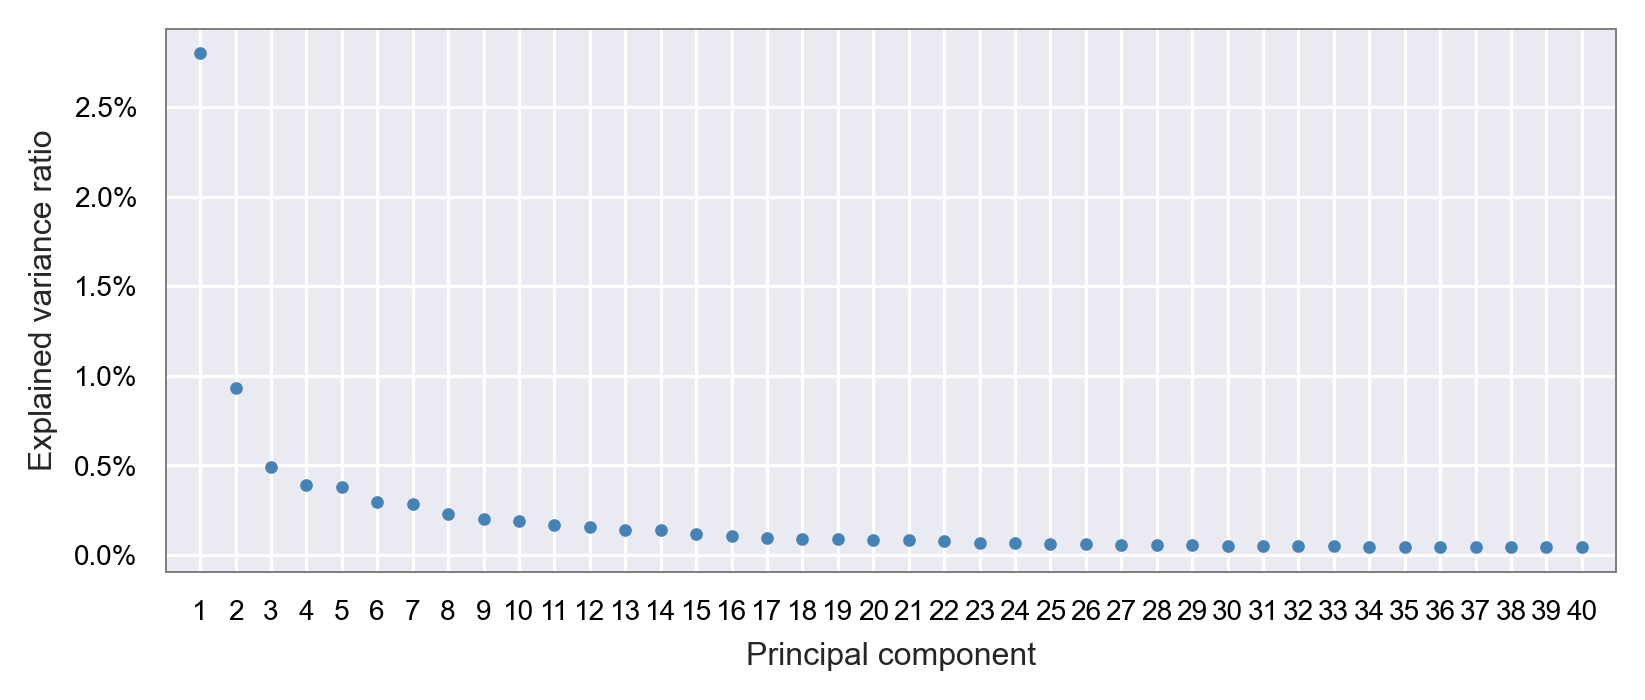

In [27]:
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6.5, 2.5))

    plot_pca_variance_explained(
        explained_variance_ratio=pca.explained_variance_ratio_,
        maximum_num_pcs=40,
        ax=ax
    )

In [28]:
file_name = ('Pyplot_pca_explained_var_ratio'
             + '_seed'
             + str(SEED_USE)
             + '.pdf')

if not Path(file_name).is_file():
    fig.savefig(fname=file_name, transparent=None, bbox_inches='tight')

In [29]:
file_name = ('principal_components'
             + '_ncomponents'
             + str(N_COMPONENTS)
             + '_seed'
             + str(SEED_USE)
             + '.npy')

if not Path(file_name).is_file():
    np.save(
        file=file_name,
        arr=principal_components,
        allow_pickle=False
    )

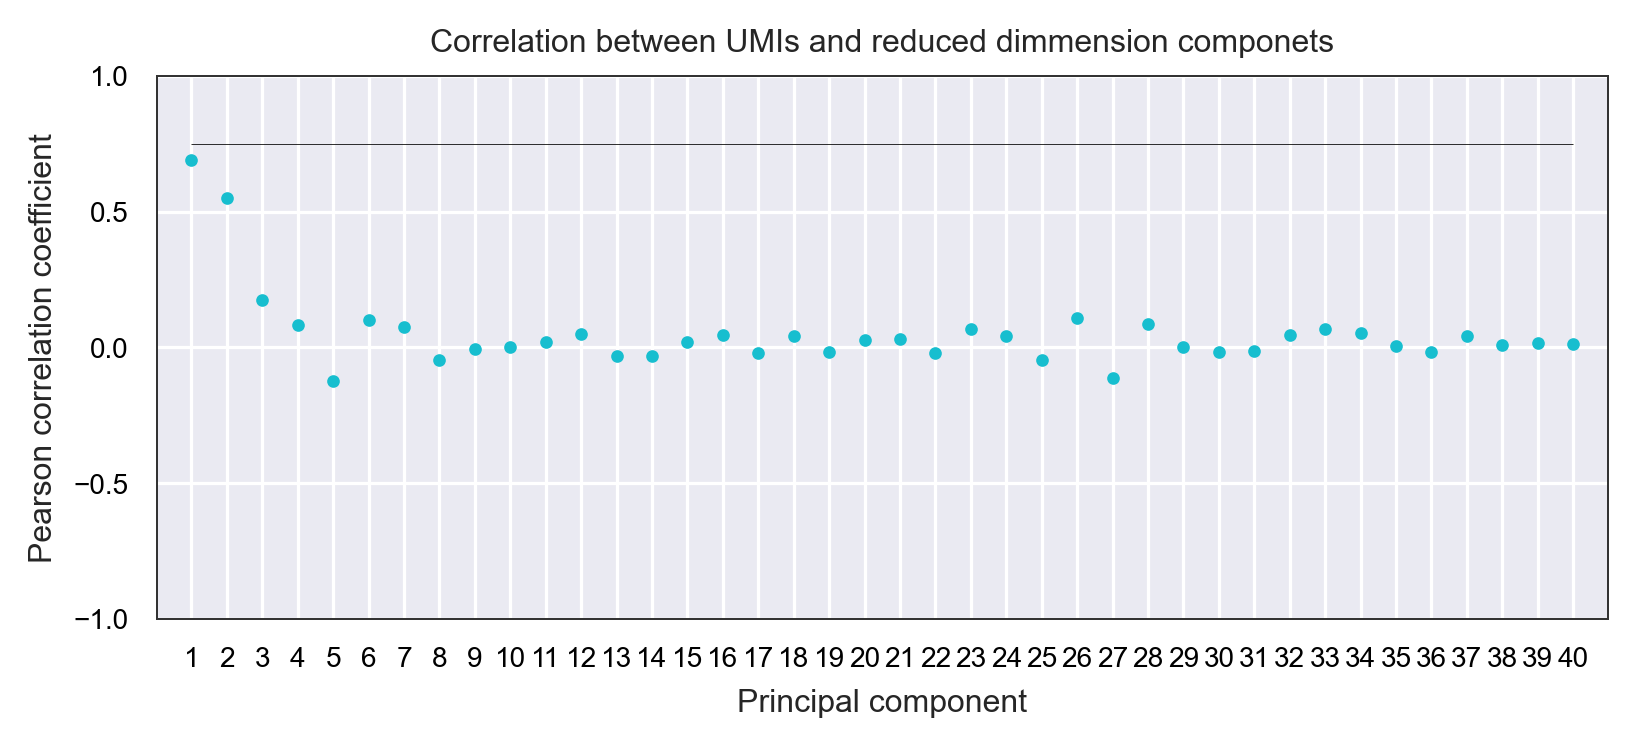

In [30]:
# Correlation between UMIs and reduced dimmension componets

N_COMPONENTS_CORR = min(40, N_COMPONENTS)
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6.5, 2.5))

ax.scatter(
    x=range(N_COMPONENTS_CORR),
    y=[
        scipy.stats.pearsonr(
            x=principal_components[:, i],
            y=np.log1p(matrix_readcount_use[:, col_idx].sum(axis=0).A1),
        )[0]
        for i in range(N_COMPONENTS_CORR)
    ],
    s=40,
    c="tab:cyan",
    marker=".",
    # cmap='viridis',
    vmin=0,
    vmax=None,
    alpha=1,
    linewidth=0,
    edgecolors=None,
)

ax.hlines(
    y=0.75,
    xmin=0,
    xmax=N_COMPONENTS_CORR - 1,
    colors='k',
    linestyles='solid',
    linewidth=0.2
)

ax.tick_params(labelsize=7, labelcolor="black")
ax.set_xticks(ticks=range(N_COMPONENTS_CORR))
ax.set_xticklabels(labels=[str(i + 1) for i in ax.get_xticks()])

ax.set_ylim(bottom=-1, top=1)
ax.set_yticks(ticks=np.linspace(start=-1, stop=1, num=5, endpoint=True))

ax.set_title(
    label="Correlation between UMIs and reduced dimmension componets",
    fontsize=8,
    loc="center",
)
ax.set_xlabel("Principal component", fontsize=8)
ax.set_ylabel("Pearson correlation coefficient", fontsize=8)

ax.margins(x=0.025, y=0.025)

for i in ["top", "bottom", "left", "right"]:
    ax.spines[i].set_linewidth(w=0.5)
    ax.spines[i].set_color(c="#333333")

In [31]:
file_name = ('Pyplot_correlation_umis_and_reduced_dimmension_componets'
             + '_ncomponents'
             + str(N_COMPONENTS)
             + '_seed'
             + str(SEED_USE)
             + '.pdf')

if not Path(file_name).is_file():
    fig.savefig(fname=file_name, transparent=None, bbox_inches='tight')

<a id='batch_effect_removal'></a>

### Batch effect removal

In [32]:
batches = adata.obs['batch'].values

pd.Series(
    data=batches
).value_counts().to_frame(name='num_cells')

num_cells
JD126B         625
PZ477          552
JD146A5        549
JD146A1        530
JD136G         500
...            ...
JD135A         101
PZ483           98
PZ590           94
JD135Z          92
PZ482           70

[93 rows x 1 columns]

In [33]:
if len(set(batches)) > 1:

    get_ipython().run_line_magic('load_ext', 'rpy2.ipython')
    get_ipython().run_cell_magic(
        'R',
        '-i principal_components -i batches -i SEED_USE -o principal_components_corrected',
        """library(harmony)
        library(magrittr)

        t1 <- Sys.time()
        
        set.seed(SEED_USE)
        principal_components_corrected <- HarmonyMatrix(
            data_mat = principal_components,
            meta_data = batches,
            do_pca = FALSE,
            theta = NULL,
            max.iter.harmony = 10,
            verbose = TRUE
        )

        t2 <- Sys.time()
        cat(t2 - t1, '\n')"""
    )

else:
    principal_components_corrected = principal_components

R[write to console]: Loading required package: Rcpp

R[write to console]: Harmony 1/10

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[

1.053461 


In [34]:
principal_components_use = principal_components_corrected[:, range(
    N_COMPONENTS_SELECTED)]
principal_components_use.shape

(25776, 18)

<a id='t-sne'></a>

## t-SNE

In [35]:
# t-SNE
embedding_tsne = TSNE(
    n_components=2,
    perplexity=30.0,
    early_exaggeration=12.0,
    learning_rate=200.0,
    n_iter=3000,
    n_iter_without_progress=300,
    min_grad_norm=1e-07,
    metric='euclidean',
    init='random',
    verbose=1,
    random_state=SEED_USE,
    method='barnes_hut',
    angle=0.5,
).fit_transform(principal_components_use)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 25776 samples in 0.040s...
[t-SNE] Computed neighbors for 25776 samples in 9.196s...
[t-SNE] Computed conditional probabilities for sample 1000 / 25776
[t-SNE] Computed conditional probabilities for sample 2000 / 25776
[t-SNE] Computed conditional probabilities for sample 3000 / 25776
[t-SNE] Computed conditional probabilities for sample 4000 / 25776
[t-SNE] Computed conditional probabilities for sample 5000 / 25776
[t-SNE] Computed conditional probabilities for sample 6000 / 25776
[t-SNE] Computed conditional probabilities for sample 7000 / 25776
[t-SNE] Computed conditional probabilities for sample 8000 / 25776
[t-SNE] Computed conditional probabilities for sample 9000 / 25776
[t-SNE] Computed conditional probabilities for sample 10000 / 25776
[t-SNE] Computed conditional probabilities for sample 11000 / 25776
[t-SNE] Computed conditional probabilities for sample 12000 / 25776
[t-SNE] Computed conditional probabilities for sam

<a id='umap'></a>

## UMAP

In [36]:
embedding_umap = umap.UMAP(
    n_neighbors=15,
    n_components=2,
    metric='euclidean',
    min_dist=0.5,
    spread=1.0,
    random_state=SEED_USE,
    transform_seed=42,
    verbose=True,
).fit_transform(principal_components_use)

UMAP(min_dist=0.5, random_state=20200602, verbose=True)
Construct fuzzy simplicial set
Tue Jun 16 01:25:28 2020 Finding Nearest Neighbors
Tue Jun 16 01:25:28 2020 Building RP forest with 13 trees
Tue Jun 16 01:25:29 2020 NN descent for 15 iterations
	 0  /  15
	 1  /  15
	 2  /  15
Tue Jun 16 01:25:42 2020 Finished Nearest Neighbor Search
Tue Jun 16 01:25:44 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Tue Jun 16 01:26:04 2020 Finished embedding


<a id='fit-sne'></a>

## FIt-SNE

In [37]:
embedding_initialization = umap.UMAP(
    n_neighbors=15,
    n_components=N_COMPONENTS,
    metric='euclidean',
    min_dist=0.1,
    spread=1.0,
    random_state=SEED_USE,
    transform_seed=42,
    verbose=True
).fit_transform(principal_components_use)


embedding_fitsne = fast_tsne(
    X=principal_components_use,
    map_dims=3,
    perplexity=30,
    initialization=embedding_initialization,
    seed=SEED_USE,
    max_iter=2000,
    df=1.0,
    nthreads=15,
)

UMAP(n_components=50, random_state=20200602, verbose=True)
Construct fuzzy simplicial set
Tue Jun 16 01:26:04 2020 Finding Nearest Neighbors
Tue Jun 16 01:26:04 2020 Building RP forest with 13 trees
Tue Jun 16 01:26:04 2020 NN descent for 15 iterations
	 0  /  15
	 1  /  15
	 2  /  15
Tue Jun 16 01:26:06 2020 Finished Nearest Neighbor Search
Tue Jun 16 01:26:06 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Tue Jun 16 01:27:12 2020 Finished embedding


<a id='phate'></a>

## PHATE

In [38]:
embedding_phate = phate.PHATE(
    n_components=2,
    knn=10,
    n_pca=N_COMPONENTS_SELECTED,
    mds_solver='smacof',
    n_jobs=-2,
    random_state=SEED_USE
).fit_transform(np.sqrt(matrix_readcount_norm.T))

Calculating PHATE...
  Running PHATE on 25776 observations and 16535 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 13.50 seconds.
    Calculating KNN search...
    Calculated KNN search in 5.00 seconds.
    Calculating affinities...
    Calculated affinities in 0.27 seconds.
  Calculated graph and diffusion operator in 18.82 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 2.96 seconds.
    Calculating KMeans...
    Calculated KMeans in 18.63 seconds.
  Calculated landmark operator in 23.98 seconds.
  Calculating optimal t...
    Automatically selected t = 28
  Calculated optimal t in 4.25 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.85 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 23.48 seconds.
Calculated PHATE in 71.39 seconds.


<a id='umap;_min_dist=0.1'></a>

## UMAP; min_dist=0.1

In [39]:
embedding_umap2 = umap.UMAP(
    n_neighbors=10,
    n_components=2,
    metric='euclidean',
    min_dist=0.1,
    spread=1.0,
    random_state=SEED_USE,
    transform_seed=42,
    verbose=True,
).fit_transform(principal_components_use)

UMAP(n_neighbors=10, random_state=20200602, verbose=True)
Construct fuzzy simplicial set
Tue Jun 16 01:28:24 2020 Finding Nearest Neighbors
Tue Jun 16 01:28:24 2020 Building RP forest with 13 trees
Tue Jun 16 01:28:24 2020 NN descent for 15 iterations
	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
Tue Jun 16 01:28:26 2020 Finished Nearest Neighbor Search
Tue Jun 16 01:28:26 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Tue Jun 16 01:28:44 2020 Finished embedding


<a id='multicoretsne'></a>

## MulticoreTSNE

In [40]:
embedding_tsne2 = TSNE_(
    n_components=2,
    perplexity=30.0,
    early_exaggeration=12,
    learning_rate=200,
    n_iter=200,
    n_iter_early_exag=250,
    n_iter_without_progress=30,
    min_grad_norm=1e-07,
    metric='euclidean',
    init='random',
    verbose=1,
    random_state=SEED_USE,
    method='barnes_hut',  # 'fft',
    angle=0.5,
    n_jobs=3,
    cheat_metric=True,
).fit_transform(principal_components_use)

<a id='clustering'></a>

# Clustering

In [41]:
adata = sc.AnnData(
    X=principal_components_use,
    obs={
        'cell': matrix_readcount_norm_barcodes,
        'batch': [re.sub('_[A-Z]{12}.bam', '', i)
                  for i in matrix_readcount_norm_barcodes],
    },
)

In [42]:
sc.pp.neighbors(
    adata=adata,
    n_neighbors=30,
    n_pcs=0,
    # use_rep=None,
    knn=True,
    random_state=SEED_USE,
    method='umap',
    metric='euclidean',
    copy=False,
)

In [43]:
sc.tl.louvain(
    adata=adata,
    resolution=None,
    random_state=SEED_USE,
    flavor='vtraag',
    directed=True,
    use_weights=False,
    partition_type=None,
    copy=False,
)

In [44]:
embedding = pd.DataFrame(
    data=np.concatenate(
        (
            adata.obs[['batch', 'louvain']],
            embedding_tsne,
            embedding_umap,
            embedding_fitsne,
            embedding_phate,
            embedding_umap2,
            embedding_tsne2
        ),
        axis=1,
    ),
    index=adata.obs['cell'],
    columns=[
        'batch',
        'louvain',
        'x_tsne',
        'y_tsne',
        'x_umap',
        'y_umap',
        'x_fitsne',
        'y_fitsne',
        'x_phate',
        'y_phate',
        'x_min_dist=0.1',
        'y_min_dist=0.1',
        'x_multicoretsne',
        'y_multicoretsne',
    ],
)

file_name = ('embedding_'
             + 'ncomponents'
             + str(N_COMPONENTS_SELECTED)
             + '_'
             + 'seed'
             + str(SEED_USE)
             + '.csv')

if not Path(file_name).is_file():
    embedding.to_csv(path_or_buf=file_name)

In [45]:
embedding = embedding.astype(
    {'louvain': int,
     'x_tsne': float,
     'y_tsne': float,
     'x_umap': float,
     'y_umap': float,
     'x_fitsne': float,
     'y_fitsne': float,
     'x_phate': float,
     'y_phate': float,

     'x_min_dist=0.1': float,
     'y_min_dist=0.1': float,
     'x_multicoretsne': float,
     'y_multicoretsne': float
     }
)

embedding.dtypes

batch               object
louvain              int64
x_tsne             float64
y_tsne             float64
x_umap             float64
y_umap             float64
x_fitsne           float64
y_fitsne           float64
x_phate            float64
y_phate            float64
x_min_dist=0.1     float64
y_min_dist=0.1     float64
x_multicoretsne    float64
y_multicoretsne    float64
dtype: object

In [46]:
embedding['louvain'].value_counts().to_frame(name='num_cells')

num_cells
0        3667
1        2893
2        2792
3        2727
4        2357
5        2206
6        1823
7        1188
8        1113
9        1023
10        982
11        913
12        608
13        491
14        406
15        157
16        128
17        121
18         97
19         84

Different resolutions

In [47]:
resolutions_selected = [0.5, 1, 1.5, 2, 3]

In [48]:
for i in resolutions_selected:
    sc.tl.louvain(
        adata=adata,
        resolution=i,
        random_state=SEED_USE,
        key_added='louvain_' + str(i),
        flavor='vtraag',
        directed=True,
        use_weights=False,
        partition_type=None,
        copy=False
    )

In [49]:
for i in resolutions_selected:
    sc.tl.leiden(
        adata=adata,
        resolution=i,
        random_state=SEED_USE,
        key_added='leiden_' + str(i),
        directed=True,
        use_weights=False,
        partition_type=None,
        copy=False
    )

<a id='visualization'></a>

# Visualization

In [50]:
embedding

batch  louvain     x_tsne      y_tsne  \
cell                                                                    
JD126-1-2_AAACACGGCACT.bam  JD126-1-2        9  91.119812   46.822094   
JD126-1-2_AAACACTGAGCG.bam  JD126-1-2        2   1.714383   79.025124   
JD126-1-2_AAACCTGGGCAA.bam  JD126-1-2       13  63.884304   -1.097956   
JD126-1-2_AAAGAGGGACAC.bam  JD126-1-2        2   7.929163   58.156288   
JD126-1-2_AAAGCTGATTCC.bam  JD126-1-2        2  22.115400  105.752129   
...                               ...      ...        ...         ...   
PZ661_TTGTATTCCTCC.bam          PZ661        2  58.894569   76.462082   
PZ661_TTTAAACCGATA.bam          PZ661        2  50.898788   72.078781   
PZ661_TTTAACCGATAN.bam          PZ661        9  73.789566   66.463898   
PZ661_TTTATACGATGC.bam          PZ661        1 -29.574249  -72.395912   
PZ661_TTTTTCCCAACA.bam          PZ661       11  92.242355   17.709795   

                              x_umap    y_umap    x_fitsne   y_fitsne  \
cell                                                                    
JD126-1-2_AAACACGGCACT.bam  0.086246  3.096919   45.346586 -31.945359   
JD126-1-2_AAACACTGAGCG.bam -7.274112  2.956917   72.349743  16.911518   
JD126-1-2_AAACCTGGGCAA.bam -0.516105  4.119554  101.996628  30.806521   
JD126-1-2_AAAGAGGGACAC.bam -5.617298  2.401112   59.256563  -8.734879   
JD126-1-2_AAAGCTGATTCC.bam -6.103518  6.733919   59.853454  43.074600   
...                              ...       ...         ...        ...   
PZ661_TTGTATTCCTCC.bam     -2.590468  5.449789   15.045417  18.911054   
PZ661_TTTAAACCGATA.bam     -3.854859  4.802749   21.355310  11.104337   
PZ661_TTTAACCGATAN.bam     -1.825126  4.578967   25.983865   3.804722   
PZ661_TTTATACGATGC.bam      7.640642 -1.844264  -71.370231  66.078613   
PZ661_TTTTTCCCAACA.bam     -0.471187  6.987431   91.962526  41.059696   

                             x_phate   y_phate  x_min_dist=0.1  \
cell                                                             
JD126-1-2_AAACACGGCACT.bam -0.019707 -0.001633       -0.950364   
JD126-1-2_AAACACTGAGCG.bam -0.023841  0.003508       -6.337228   
JD126-1-2_AAACCTGGGCAA.bam -0.016012 -0.008612       -2.489724   
JD126-1-2_AAAGAGGGACAC.bam -0.023153  0.002085       -5.450979   
JD126-1-2_AAAGCTGATTCC.bam -0.022570  0.003222       -4.730167   
...                              ...       ...             ...   
PZ661_TTGTATTCCTCC.bam     -0.017215  0.009552       -2.920950   
PZ661_TTTAAACCGATA.bam     -0.017646  0.009802       -3.650925   
PZ661_TTTAACCGATAN.bam     -0.017693  0.009659       -2.175899   
PZ661_TTTATACGATGC.bam      0.001141 -0.012312        8.172877   
PZ661_TTTTTCCCAACA.bam     -0.014299  0.007916       -1.015578   

                            y_min_dist=0.1  x_multicoretsne  y_multicoretsne  
cell                                                                          
JD126-1-2_AAACACGGCACT.bam        5.894135        -1.478159        -1.369312  
JD126-1-2_AAACACTGAGCG.bam        5.829054        -2.791940        -2.290890  
JD126-1-2_AAACCTGGGCAA.bam        8.255121        -1.935610        -2.105476  
JD126-1-2_AAAGAGGGACAC.bam        6.293232        -2.485247        -2.192436  
JD126-1-2_AAAGCTGATTCC.bam        2.974775        -3.321329        -1.519606  
...                                    ...              ...              ...  
PZ661_TTGTATTCCTCC.bam            4.584495        -2.599656        -1.117372  
PZ661_TTTAAACCGATA.bam            4.707261        -2.739021        -1.289242  
PZ661_TTTAACCGATAN.bam            5.015847        -2.338425        -1.212409  
PZ661_TTTATACGATGC.bam           14.398257         1.889964         0.782026  
PZ661_TTTTTCCCAACA.bam            2.593106        -3.134536        -2.740858  

[25776 rows x 14 columns]

In [51]:
embedding['batch'].unique()

array(['JD126-1-2', 'JD126A1', 'JD126A5', 'JD126B', 'JD131-A', 'JD131-B',
       'JD131-C', 'JD135A', 'JD135Y', 'JD135Z', 'JD136A', 'JD136B',
       'JD136C', 'JD136DE', 'JD136F', 'JD136G', 'JD137A', 'JD145A1',
       'JD145A5', 'JD145B1', 'JD145B5', 'JD145C', 'JD145D', 'JD145E',
       'JD145F', 'JD146A1', 'JD146A5', 'JD146B1', 'JD146B5', 'JD146C1',
       'JD146C5', 'JD149A', 'JD149B', 'JD149C', 'JD149D', 'JD149E',
       'JD150-3A', 'JD150-3B', 'JD150-3C', 'JD150-4A', 'JD150-4B',
       'JD150A', 'JD150B', 'JD150C', 'JD150D', 'JD164_165', 'JD166_167',
       'JD168A', 'JD168B', 'JD168C', 'JD168_169', 'JD169A', 'JD169B',
       'JD169C', 'JD170A', 'JD170B', 'JD170C', 'JD170_171', 'JD171A',
       'JD171B', 'JD171C', 'PZ473', 'PZ474', 'PZ475', 'PZ476', 'PZ477',
       'PZ478', 'PZ479', 'PZ480', 'PZ481', 'PZ482', 'PZ483', 'PZ484',
       'PZ485', 'PZ486', 'PZ487', 'PZ492', 'PZ493', 'PZ496', 'PZ497',
       'PZ580', 'PZ581', 'PZ582', 'PZ583', 'PZ584', 'PZ585', 'PZ586',
       'PZ587', '

In [52]:
embedding['category'] = embedding['batch'].map(
    {
        'JD126-1-2': 'JD131',
        'JD131-A': 'JD131',
        'JD131-B': 'JD131',
        'JD131-C': 'JD131',
        'JD135A': 'JD135',
        'JD136A': 'JD136',
        'JD137A': 'JD137',
        'JD126A1': 'JD131',
        'JD126A5': 'JD131',
        'JD126B': 'JD131',
        'JD145A1': 'JD136',
        'JD145A5': 'JD136',
        'JD145B1': 'JD136',
        'JD145B5': 'JD136',
        'JD146A1': 'JD146',
        'JD146A5': 'JD146',
        'JD146B1': 'JD146',
        'JD146B5': 'JD146',
        'JD146C1': 'JD146',
        'JD146C5': 'JD146',
        'JD145C': 'JD136',
        'JD145D': 'JD136',
        'JD145E': 'JD136',
        'JD149A': 'JD136',
        'JD149B': 'JD136',
        'JD150A': 'JD136',
        'JD150B': 'JD136',
        'JD145F': 'JD136',
        'JD149C': 'JD136',
        'JD149D': 'JD136',
        'JD149E': 'JD136',
        'JD136B': 'JD136',
        'JD136C': 'JD136',
        'JD136DE': 'JD136',
        'JD136F': 'JD136',
        'JD136G': 'JD136',
        'JD150C': 'JD136',
        'JD150D': 'JD136',
        'JD150-3A': 'JD136',
        'JD150-3B': 'JD136',
        'JD164_165': 'JD168',
        'JD166_167': 'JD168',
        'JD168_169': 'JD168',
        'JD168A': 'JD168',
        'JD168B': 'JD168',
        'JD168C': 'JD168',
        'JD169A': 'JD168',
        'JD169B': 'JD168',
        'JD169C': 'JD168',
        'JD170A': 'JD168',
        'JD170B': 'JD168',
        'JD170C': 'JD168',
        'JD171A': 'JD168',
        'JD171B': 'JD168',
        'JD171C': 'JD168',
        'JD150-3C': 'JD136',
        'JD170_171': 'JD168',
        'PZ473': 'JD168',
        'PZ474': 'JD168',
        'PZ475': 'JD168',
        'PZ476': 'JD168',
        'PZ477': 'JD168',
        'PZ478': 'JD168',
        'PZ479': 'JD168',
        'PZ480': 'JD168',
        'PZ481': 'JD168',
        'PZ482': 'JD168',
        'PZ483': 'JD168',
        'PZ484': 'JD168',
        'PZ485': 'JD168',
        'PZ486': 'JD168',
        'PZ487': 'JD168',
        'PZ492': 'JD136',
        'PZ493': 'JD136',
        'PZ496': 'JD174',
        'PZ497': 'JD174',
        'JD150-4A': 'JD136',
        'JD150-4B': 'JD136',
        'PZ580': 'JD168',
        'PZ581': 'JD168',
        'PZ582': 'JD168',
        'PZ583': 'JD168',
        'PZ584': 'JD168',
        'PZ585': 'JD168',
        'PZ586': 'JD174',
        'PZ587': 'JD174',
        'PZ588': 'JD174',
        'PZ589': 'JD174',
        'PZ590': 'JD174',
        'PZ660': 'JD135',
        'PZ661': 'JD135',
        'JD135Z': 'JD135',
        'JD135Y': 'JD135',
    }
)

In [53]:
embedding['category'].value_counts().to_frame(name='num_cells')

num_cells
JD136       9127
JD168       8730
JD146       2861
JD131       2729
JD174       1362
JD135        699
JD137        268

<a id='embedding'></a>

## Embedding

<a id='embedding_cluster'></a>

### Cluster

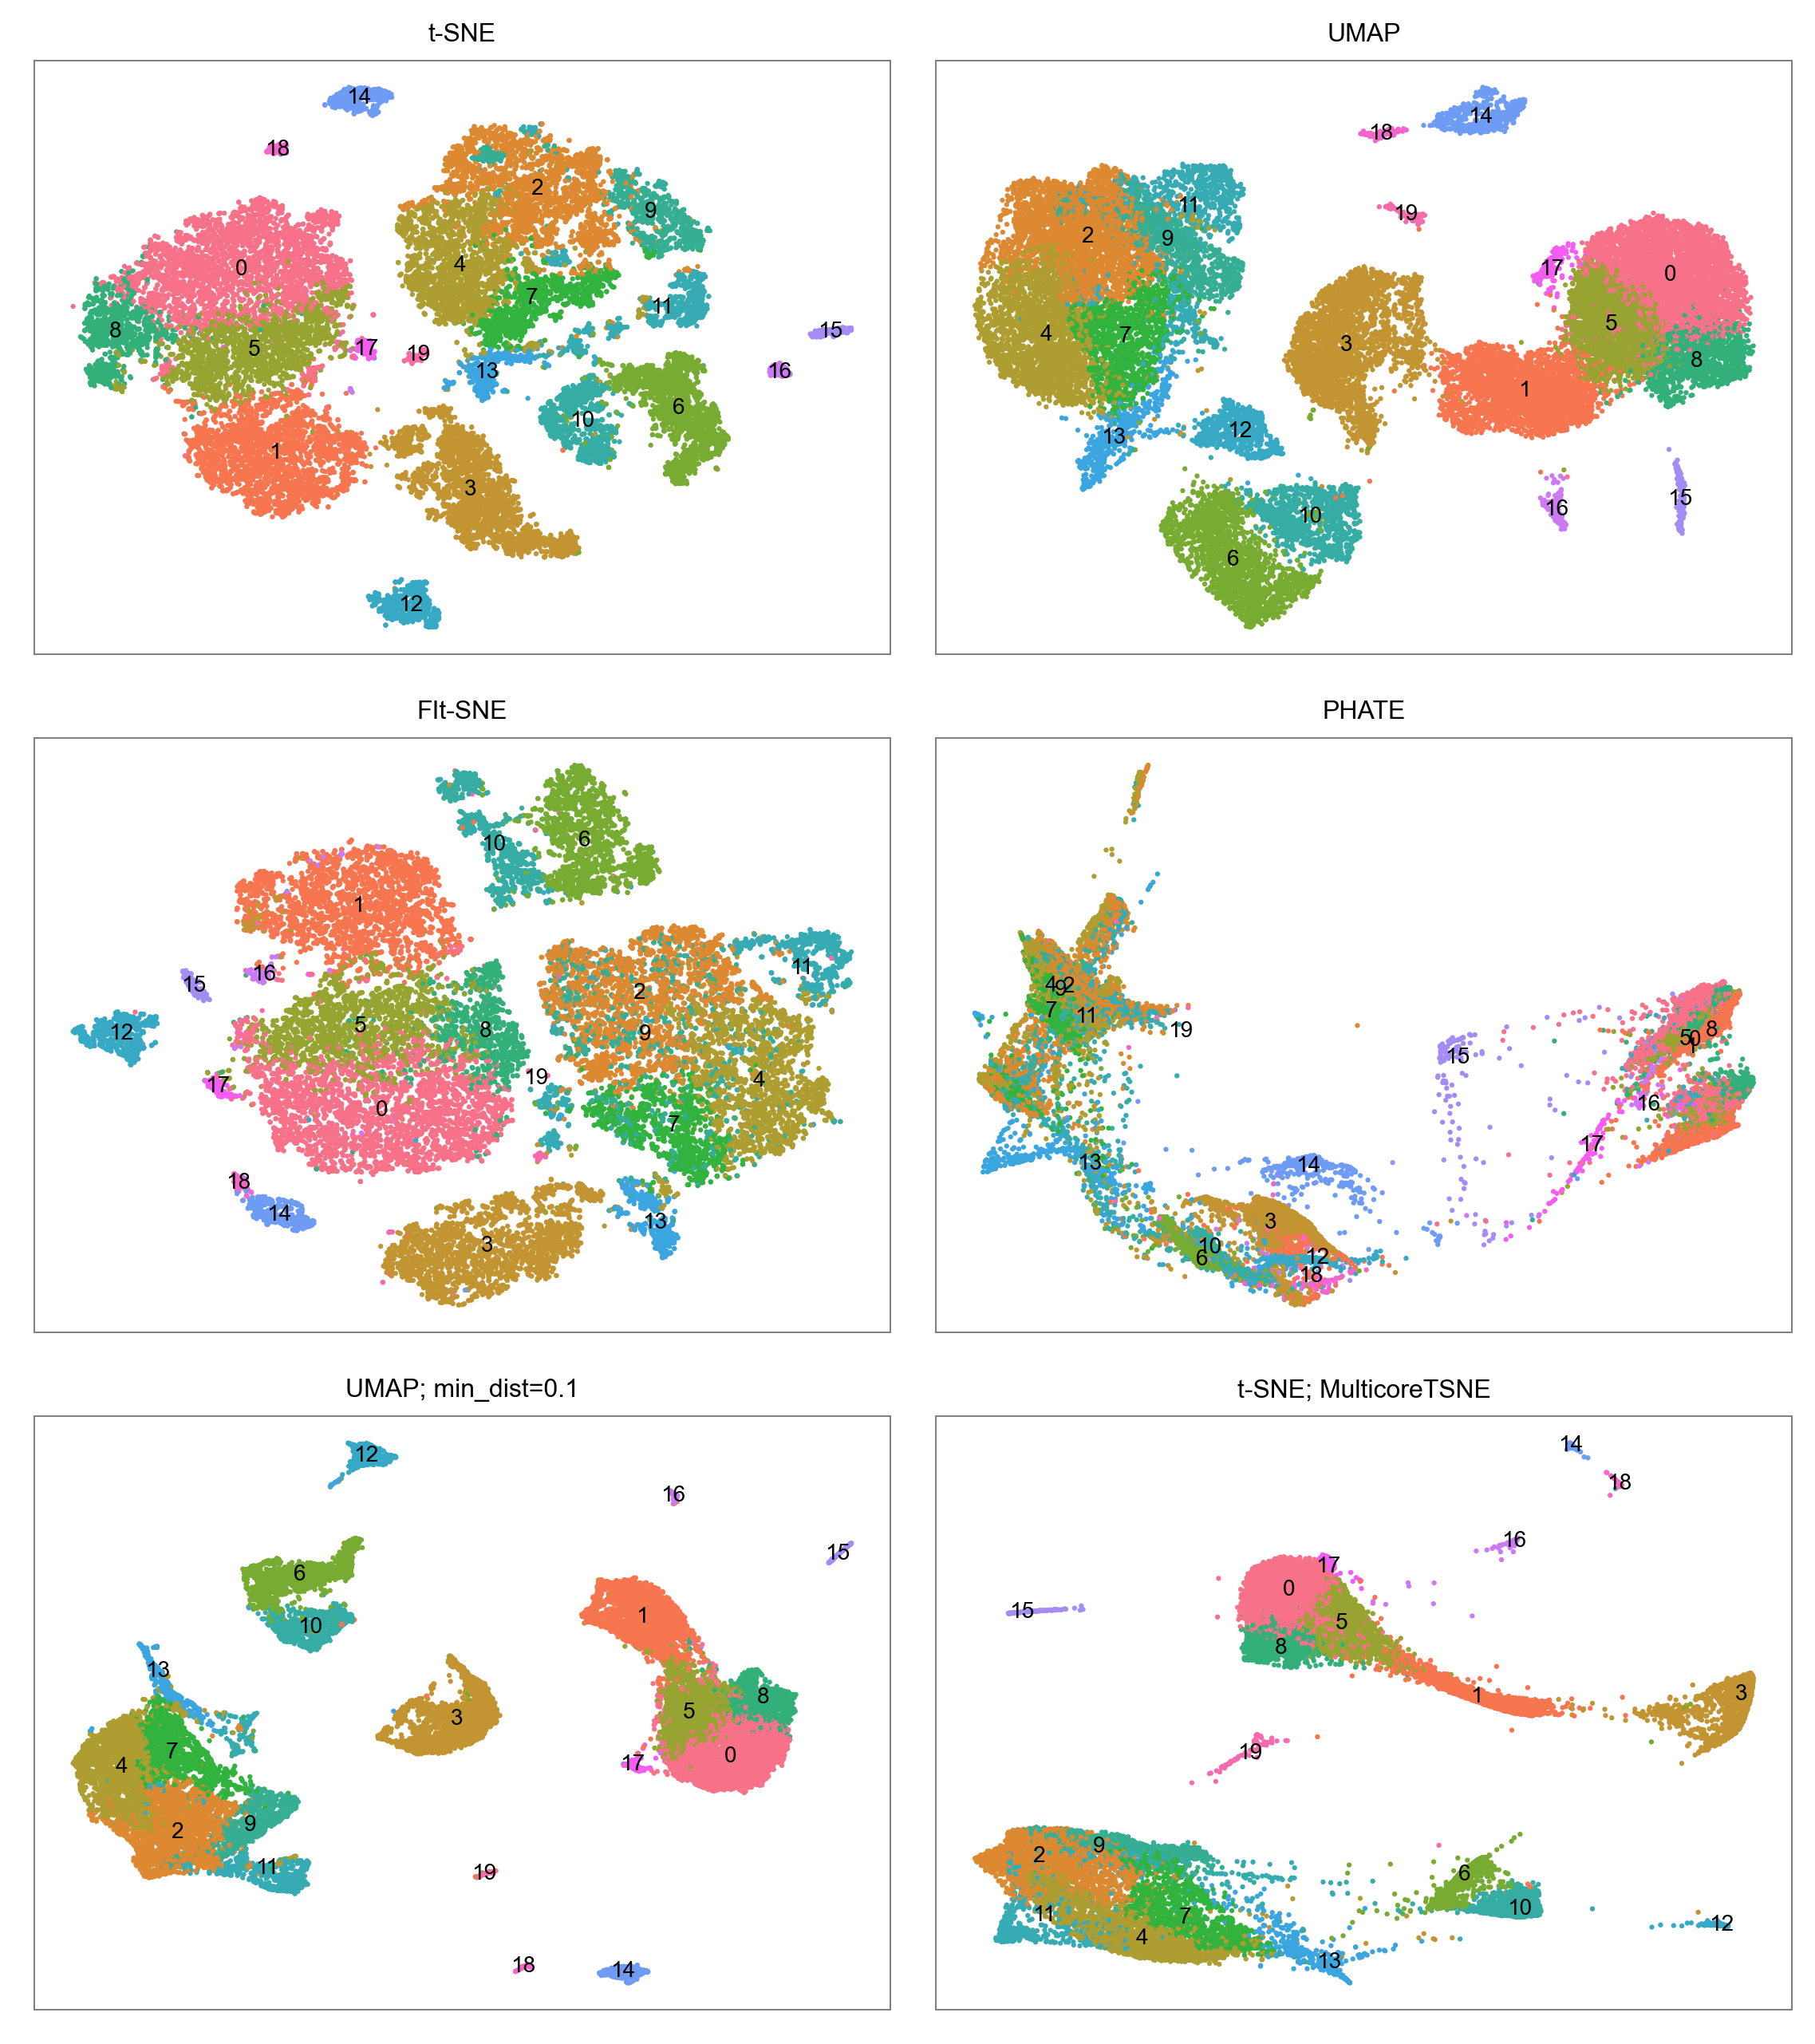

In [54]:
fig, axes = plt.subplots(nrows=1 * 3, ncols=1 * 2, figsize=(4 * 2, 3 * 3))
axes = axes.flatten()

plot_embedding(
    embedding=embedding[['x_tsne', 'y_tsne']],
    ax=axes[0],
    title='t-SNE',
    group=embedding['louvain'],
    show_group_labels=True,
)

plot_embedding(
    embedding=embedding[['x_umap', 'y_umap']],
    ax=axes[1],
    title='UMAP',
    group=embedding['louvain'],
    show_group_labels=True,
)

plot_embedding(
    embedding=embedding[['x_fitsne', 'y_fitsne']],
    ax=axes[2],
    title='FIt-SNE',
    group=embedding['louvain'],
    show_group_labels=True,
)

plot_embedding(
    embedding=embedding[['x_phate', 'y_phate']],
    ax=axes[3],
    title='PHATE',
    group=embedding['louvain'],
    show_group_labels=True,
)

plot_embedding(
    embedding=embedding[['x_min_dist=0.1', 'y_min_dist=0.1']],
    ax=axes[4],
    title='UMAP; min_dist=0.1',
    group=embedding['louvain'],
    show_group_labels=True,
)

plot_embedding(
    embedding=embedding[['x_multicoretsne', 'y_multicoretsne']],
    ax=axes[5],
    title='t-SNE; MulticoreTSNE',
    group=embedding['louvain'],
    show_group_labels=True,
)

plt.tight_layout()

In [55]:
file_name = ('Pyplot_embedding_'
             + 'ncomponents'
             + str(N_COMPONENTS_SELECTED)
             + '_'
             + 'seed'
             + str(SEED_USE)
             + '.pdf')

if not Path(file_name).is_file():
    fig.savefig(fname=file_name, transparent=None, bbox_inches='tight')

<a id='embedding_sample'></a>

### Sample

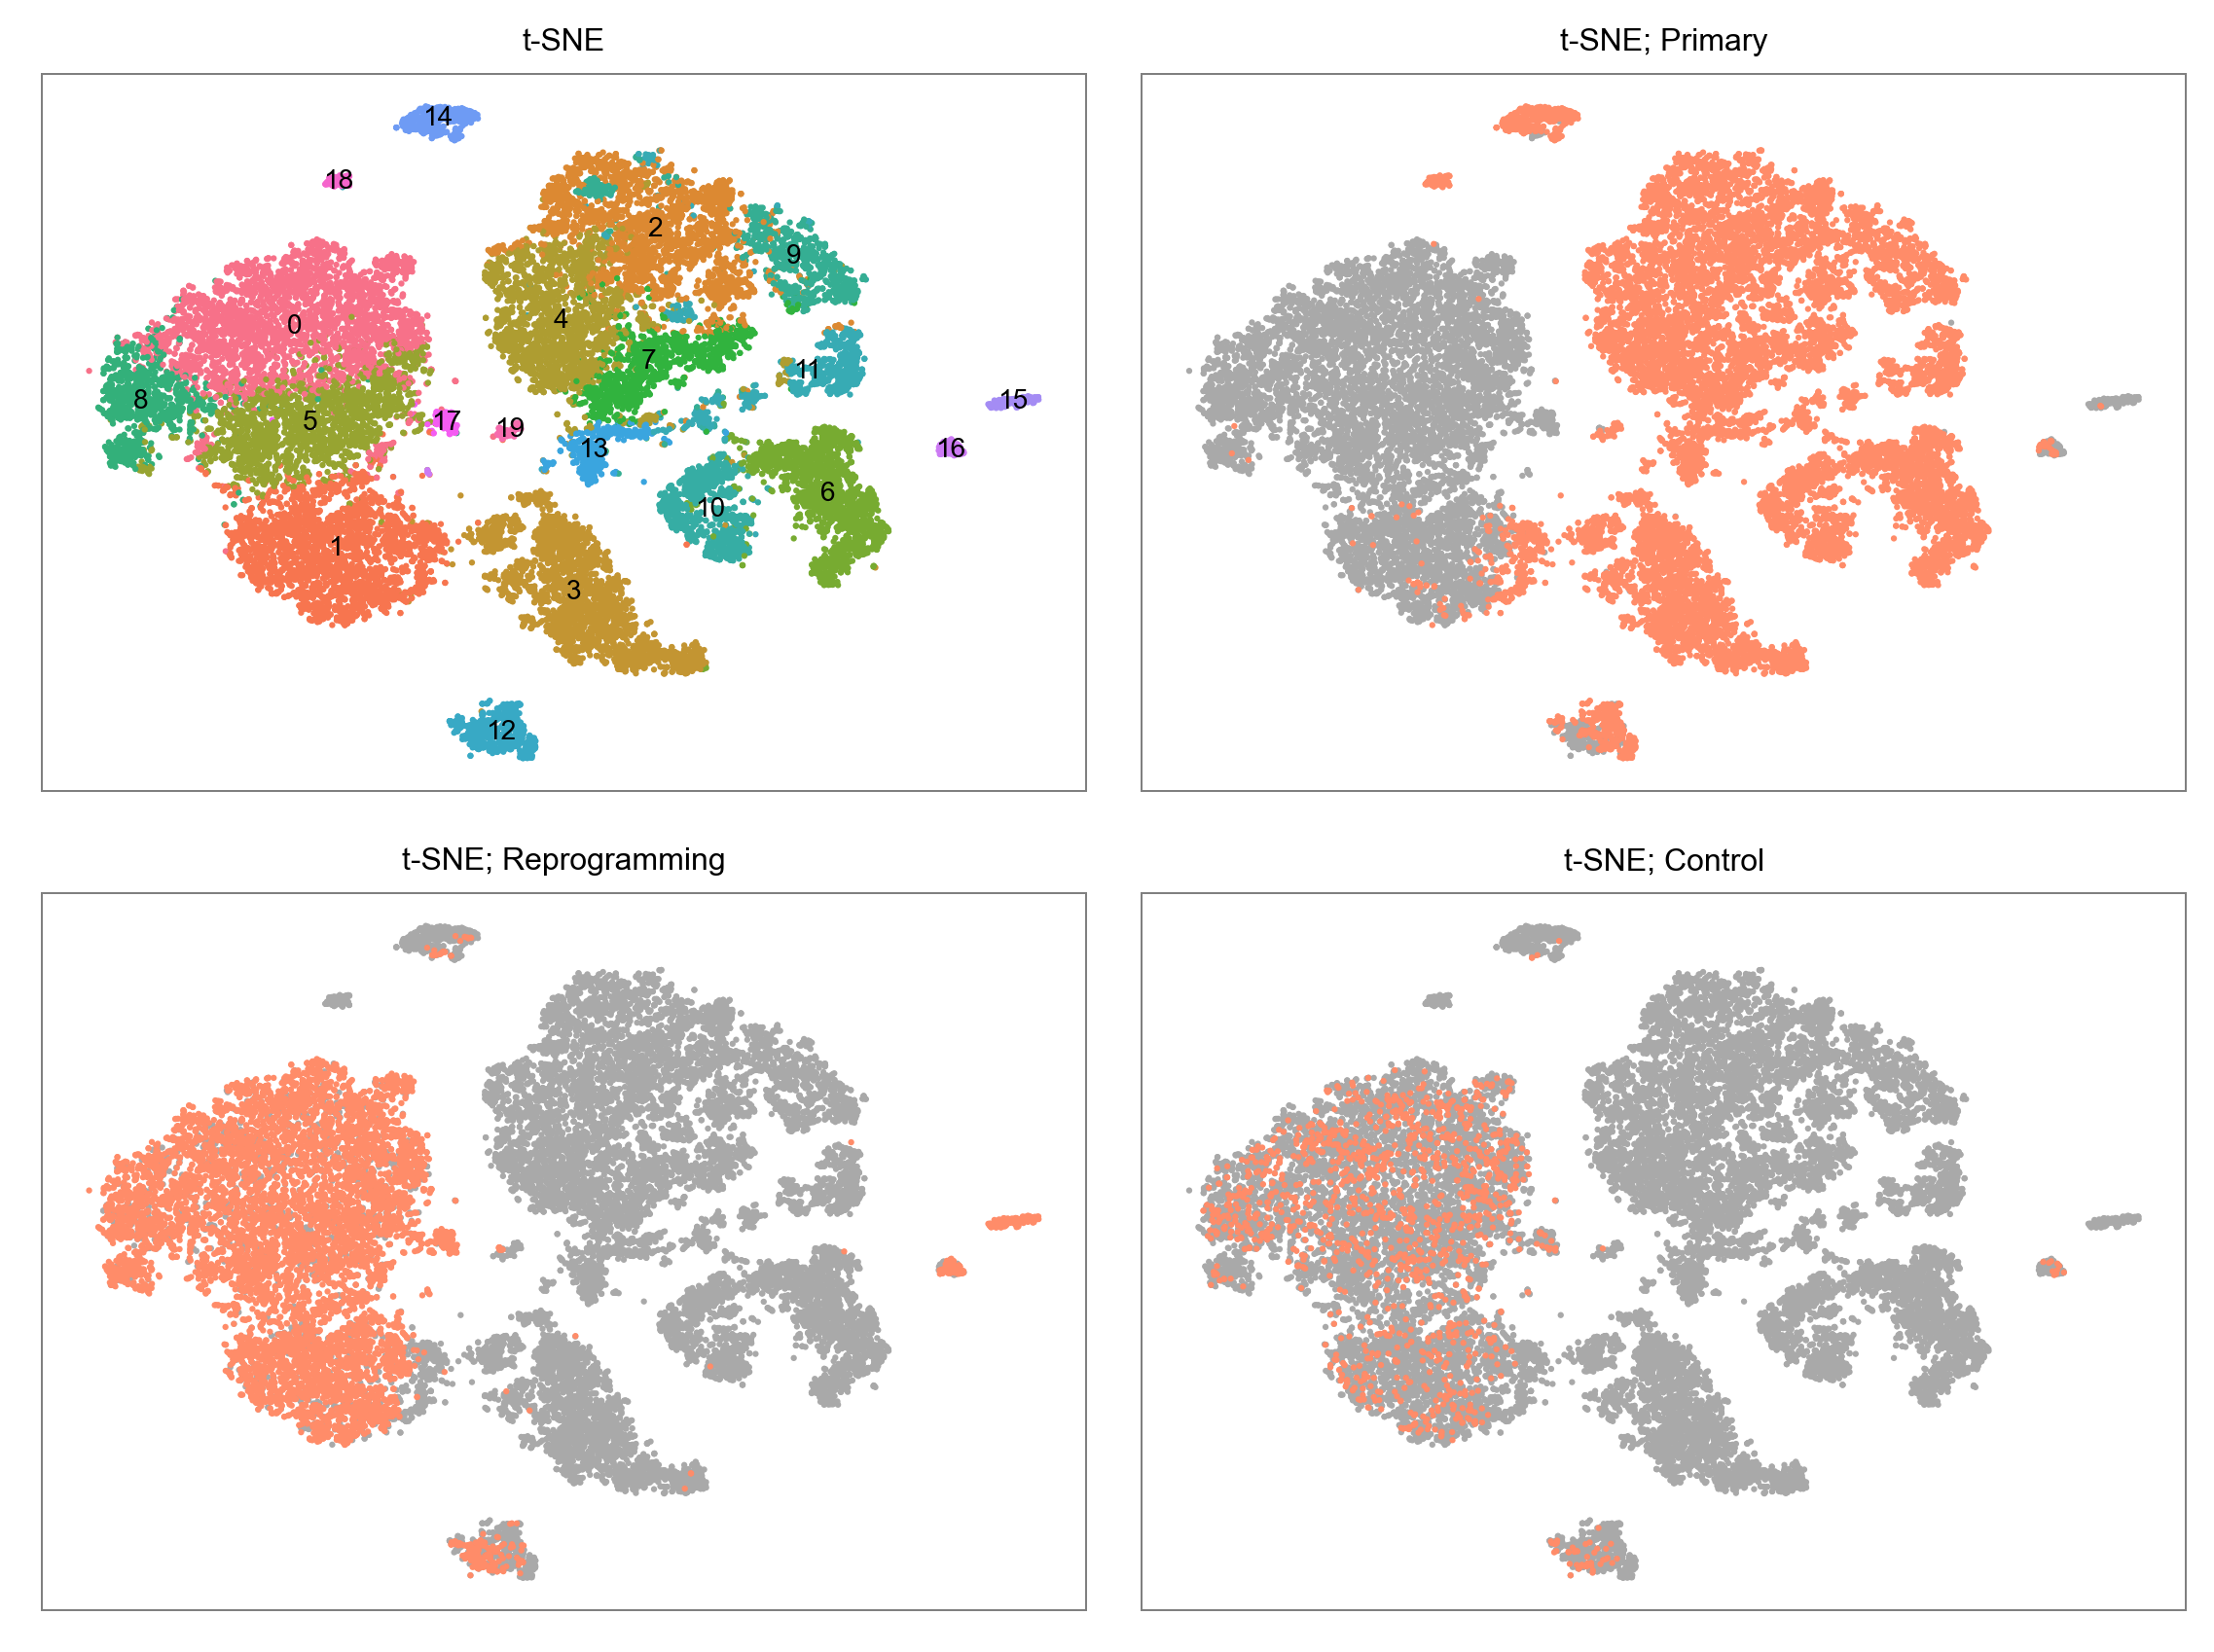

In [56]:
fig, axes = plt.subplots(nrows=1 * 2, ncols=1 * 2, figsize=(4 * 2, 3 * 2))
axes = axes.flatten()

plot_embedding(
    embedding=embedding[['x_tsne', 'y_tsne']],
    ax=axes[0],
    title='t-SNE',
    group=embedding['louvain'],
    show_group_labels=True,
)

plot_embedding(
    embedding=embedding[['x_tsne', 'y_tsne']],
    ax=axes[1],
    title='t-SNE; Primary',

    group=embedding.index.values[~np.isin(
        embedding.category.values, ['JD168', 'JD174'])],
    show_group_labels=False
)

plot_embedding(
    embedding=embedding[['x_tsne', 'y_tsne']],
    ax=axes[2],
    title='t-SNE; Reprogramming',

    group=embedding.index.values[embedding['category'] == 'JD168'],
    show_group_labels=False
)

plot_embedding(
    embedding=embedding[['x_tsne', 'y_tsne']],
    ax=axes[3],
    title='t-SNE; Control',

    group=embedding.index.values[embedding['category'] == 'JD174'],
    show_group_labels=False
)

plt.tight_layout()

<a id='embedding_resolution'></a>

### Resolution

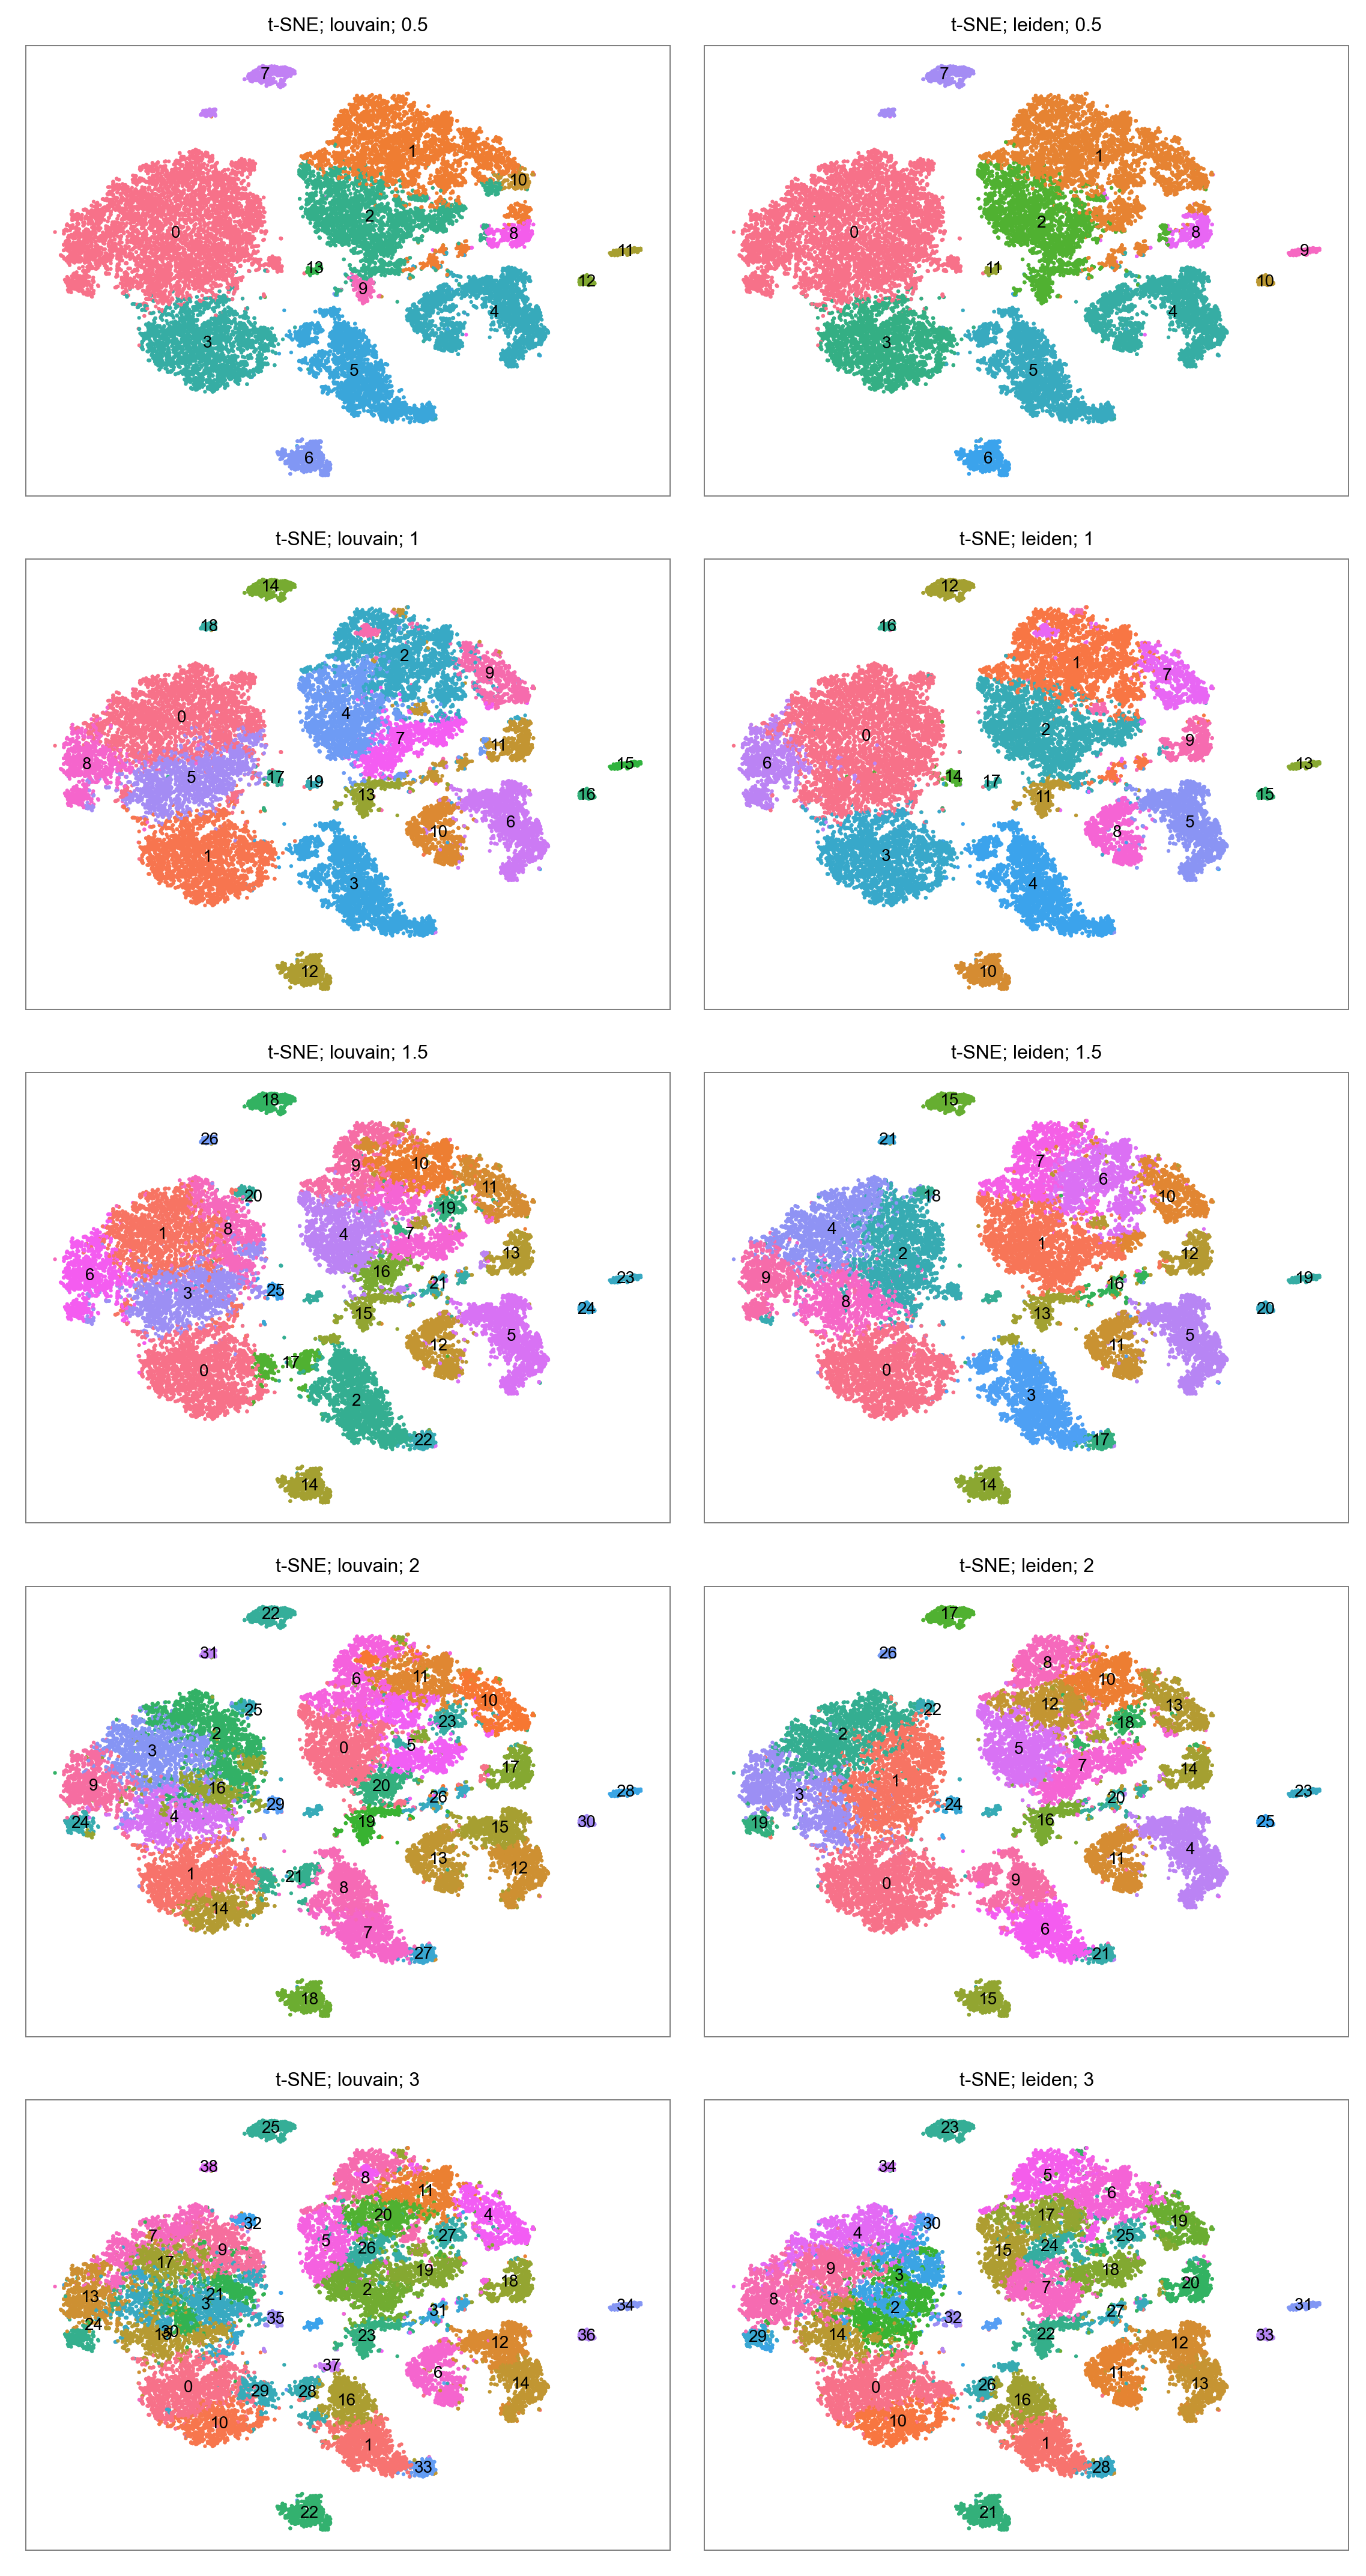

In [57]:
fig, axes = plt.subplots(
    nrows=1 * len(resolutions_selected),
    ncols=1 * 2,
    figsize=(4 * 2, 3 * len(resolutions_selected)))
# axes = axes.flatten()

for index, resolution in enumerate(resolutions_selected):

    for i, j in enumerate(['louvain', 'leiden']):

        plot_embedding(
            embedding=embedding_tsne,
            ax=axes[index][i],
            title='t-SNE; ' + j + '; ' + str(resolution),
            group=adata.obs[j + '_' + str(resolution)],
            show_group_labels=True,
        )

plt.tight_layout()

<a id='cluster_distribution'></a>

## Cluster distribution

<a id='cluster_distribution_batch'></a>

### Batch

In [58]:
embedding['category_annotated'] = embedding.category.map(
    {
        'JD131': 'Whole heart',
        'JD135': 'Left atrium (LA)',
        'JD136': 'Right atrium (RA)',
        'JD137': 'Remainder (except LA RA)',
        'JD146': 'Remainder (except RA)',
        'JD168': 'Reprogramming',
        'JD174': 'Control'
    }
)

In [59]:
embedding['category_annotated'].value_counts()

Right atrium (RA)           9127
Reprogramming               8730
Remainder (except RA)       2861
Whole heart                 2729
Control                     1362
Left atrium (LA)             699
Remainder (except LA RA)     268
Name: category_annotated, dtype: int64

In [60]:
louvain_order = list(reversed(embedding['louvain'].sort_values().unique()))

In [61]:
# batch_order = list(embedding['category'].unique())
batch_order = [
    'Whole heart',
    'Left atrium (LA)',
    'Right atrium (RA)',
    'Remainder (except LA RA)',
    'Remainder (except RA)',
    'Reprogramming',
    'Control'
]

In [62]:
cluster_composition = prepare_cluster_composition(
    embedding=embedding,
    cluster_column='louvain',
    composition_column='category_annotated',
    cluster_column_order=louvain_order,
    composition_column_order=batch_order
)

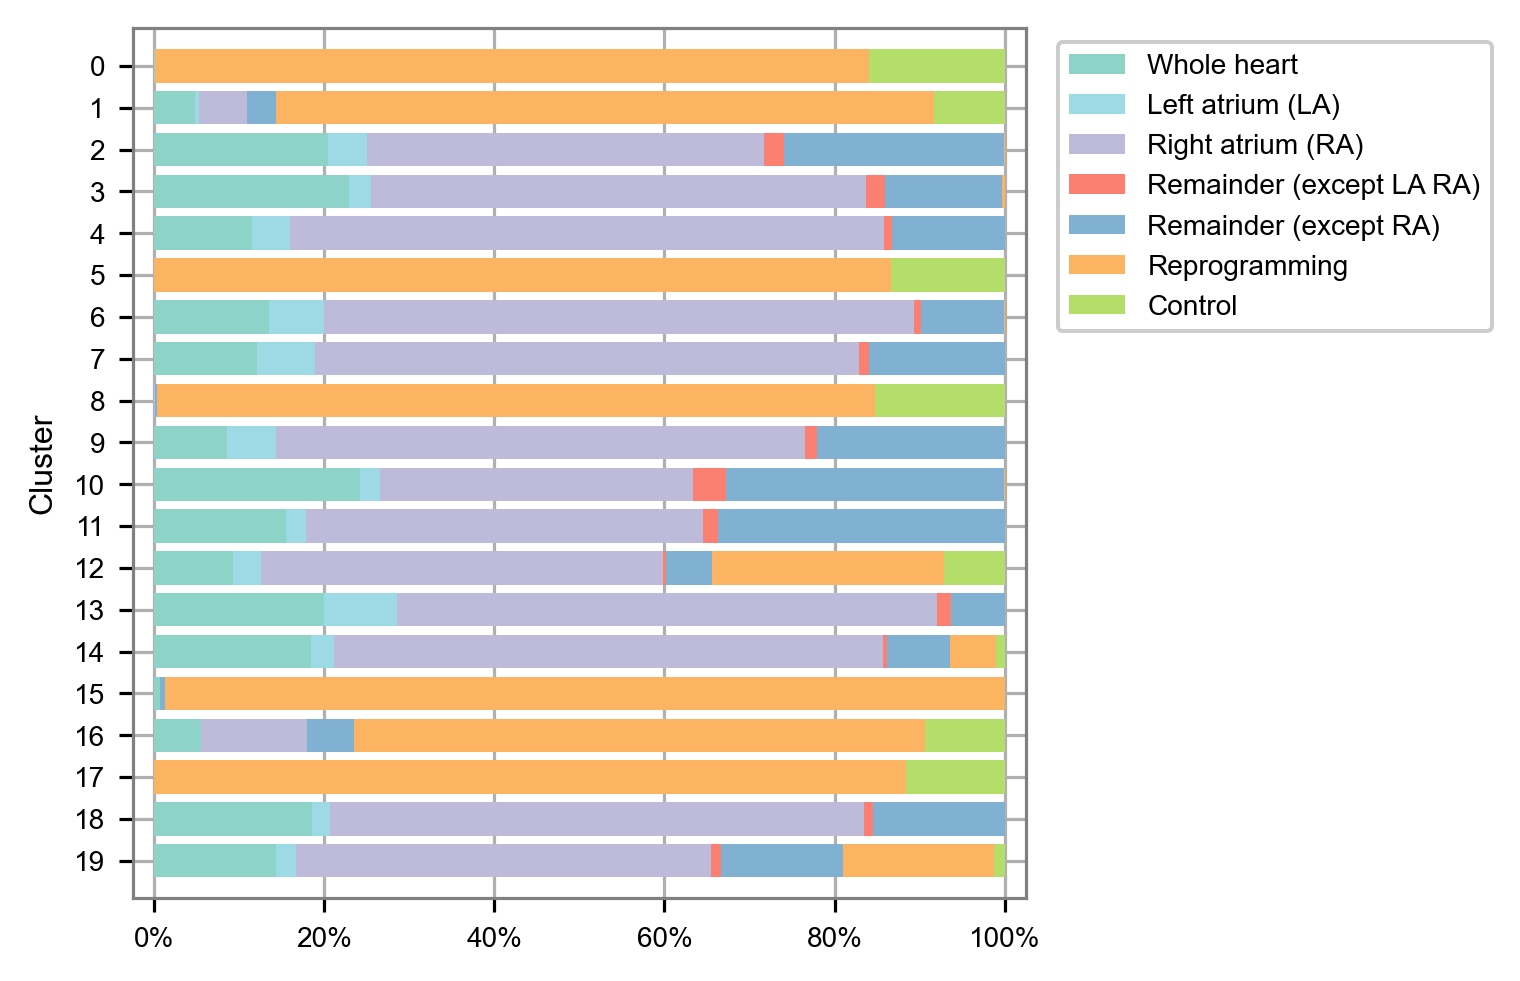

In [63]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

plot_cluster_composition(
    cluster_composition=cluster_composition,
    x='category_annotated',
    y='louvain',
    ax=ax,
    x_order=batch_order,
    y_order=louvain_order,
    colors=['#8DD3C7', '#9EDAE5FF', '#BEBADA', '#FB8072',
            '#80B1D3', '#FDB462', '#B3DE69', '#FCCDE5']
)

In [64]:
file_name = 'Pyplot_distribution_sample.pdf'

if not Path(file_name).is_file():
    fig.savefig(fname=file_name, transparent=None, bbox_inches='tight')

<a id='cluster_distribution_sample'></a>

### Sample

In [65]:
embedding['category_annotated'] = embedding.category.map(
    {
        'JD131': 'Primary',
        'JD135': 'Primary',
        'JD136': 'Primary',
        'JD137': 'Primary',
        'JD146': 'Primary',
        'JD168': 'Reprogramming',
        'JD174': 'Control'
    }
)

In [66]:
embedding['category_annotated'].value_counts()

Primary          15684
Reprogramming     8730
Control           1362
Name: category_annotated, dtype: int64

In [67]:
louvain_order = list(reversed(embedding['louvain'].sort_values().unique()))

In [68]:
# batch_order = list(embedding['category'].unique())
batch_order = [
    'Primary',
    'Reprogramming',
    'Control'
]

In [69]:
cluster_composition = prepare_cluster_composition(
    embedding=embedding,
    cluster_column='louvain',
    composition_column='category_annotated',
    cluster_column_order=louvain_order,
    composition_column_order=batch_order
)

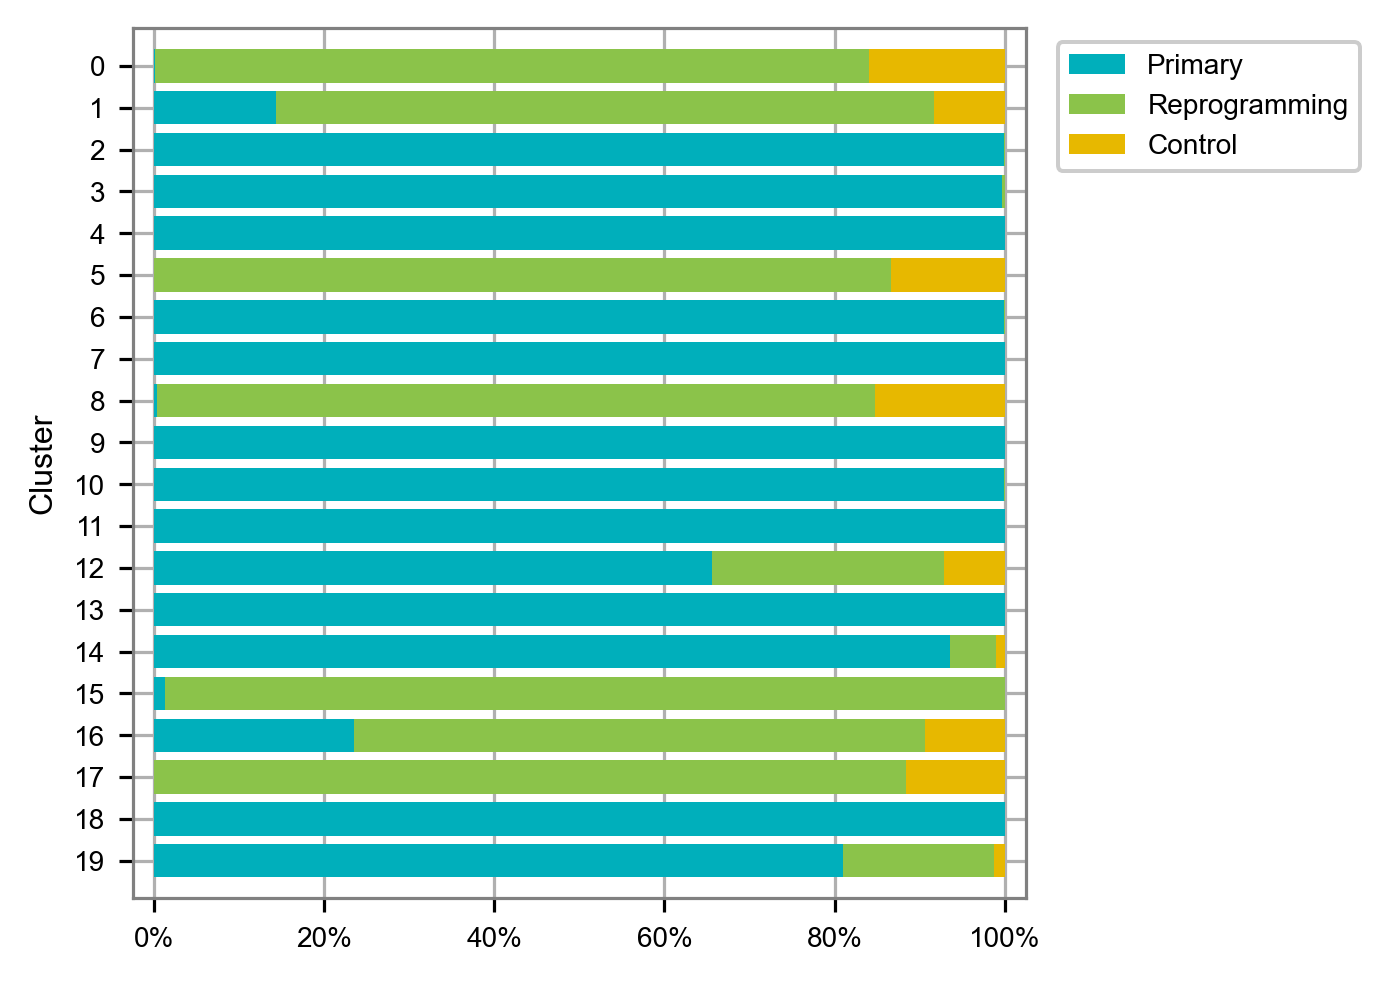

In [70]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

plot_cluster_composition(
    cluster_composition=cluster_composition,
    x='category_annotated',
    y='louvain',
    ax=ax,
    x_order=batch_order,
    y_order=louvain_order,
    colors=['#00AFBB', '#8BC34A', '#E7B800']
)

<a id='expression'></a>

## Expression

In [71]:
"""
# load data
matrix_readcount_use = scipy.sparse.load_npz(
    file=DATA_DIR / 'matrix_readcount.npz')

matrix_readcount_use_barcodes = np.load(
    file=DATA_DIR / 'matrix_readcount_barcodes.npy')

matrix_readcount_use_features = np.load(
    file=DATA_DIR / 'matrix_readcount_features.npy')

"""

"\n# load data\nmatrix_readcount_use = scipy.sparse.load_npz(\n    file=DATA_DIR / 'matrix_readcount.npz')\n\nmatrix_readcount_use_barcodes = np.load(\n    file=DATA_DIR / 'matrix_readcount_barcodes.npy')\n\nmatrix_readcount_use_features = np.load(\n    file=DATA_DIR / 'matrix_readcount_features.npy')\n\n"

In [72]:
# calculate CPM
matrix_cpm_use = matrix_readcount_use.copy()
matrix_cpm_use.data = (
    1_000_000
    * matrix_cpm_use.data
    / np.repeat(matrix_cpm_use.sum(axis=0).A1, np.diff(matrix_cpm_use.indptr))
)

In [73]:
# create anndata object, CPM

adata_cpm = sc.AnnData(
    X=matrix_cpm_use.T,
    obs={
        'cell': matrix_readcount_use_barcodes,
        'batch': [re.sub('_[A-Z]{16}$', '', i) for i in matrix_readcount_use_barcodes],
    },
    var={'feature': matrix_readcount_use_features},
)

adata_cpm.obs.index = adata_cpm.obs['cell']
adata_cpm.var.index = adata_cpm.var['feature']

In [74]:
[matrix_readcount_use_features[i]
 for i in np.where([re.search(pattern='vwf', string=i.lower())
                    for i in matrix_readcount_use_features])]

[array(['ENSMUSG00000001930_Vwf'], dtype='<U33')]

In [75]:
FEATURES_SELECTED = [
    'ENSMUSG00000009471_Myod1',
    'ENSMUSG00000016458_Wt1',
    'ENSMUSG00000025105_Bnc1',
    'ENSMUSG00000031517_Gpm6a',
    'ENSMUSG00000049436_Upk1b',
    'ENSMUSG00000026414_Tnnt2',
    'ENSMUSG00000013936_Myl2',
    'ENSMUSG00000042045_Sln',
    'ENSMUSG00000001506_Col1a1',
    'ENSMUSG00000001930_Vwf'
]

Myod1
Wt1
Bnc1
Gpm6a
Upk1b
Tnnt2
Myl2
Sln
Col1a1
Vwf


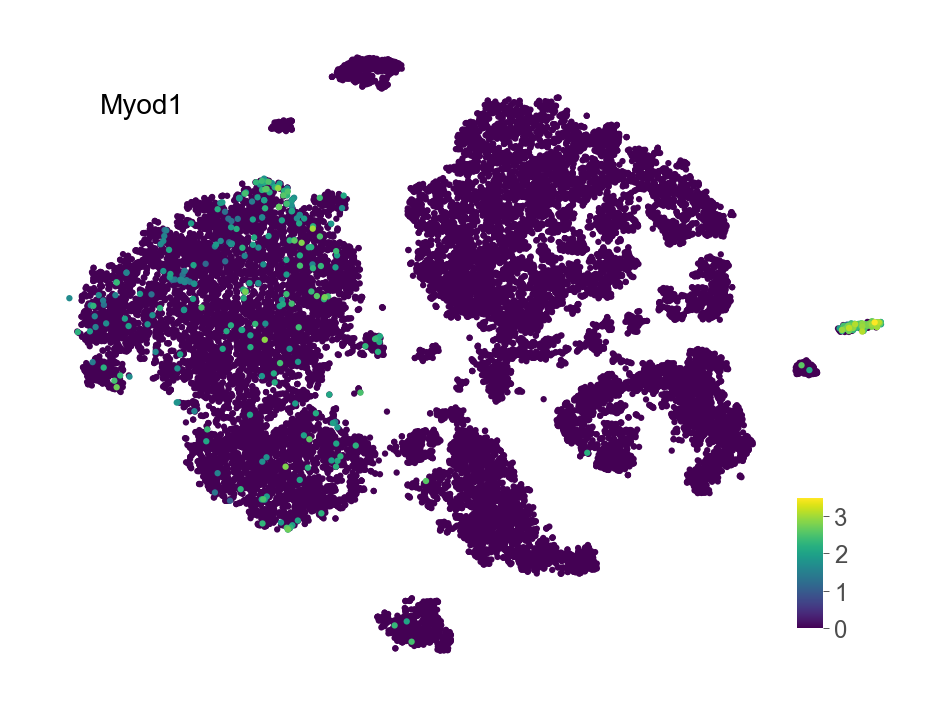

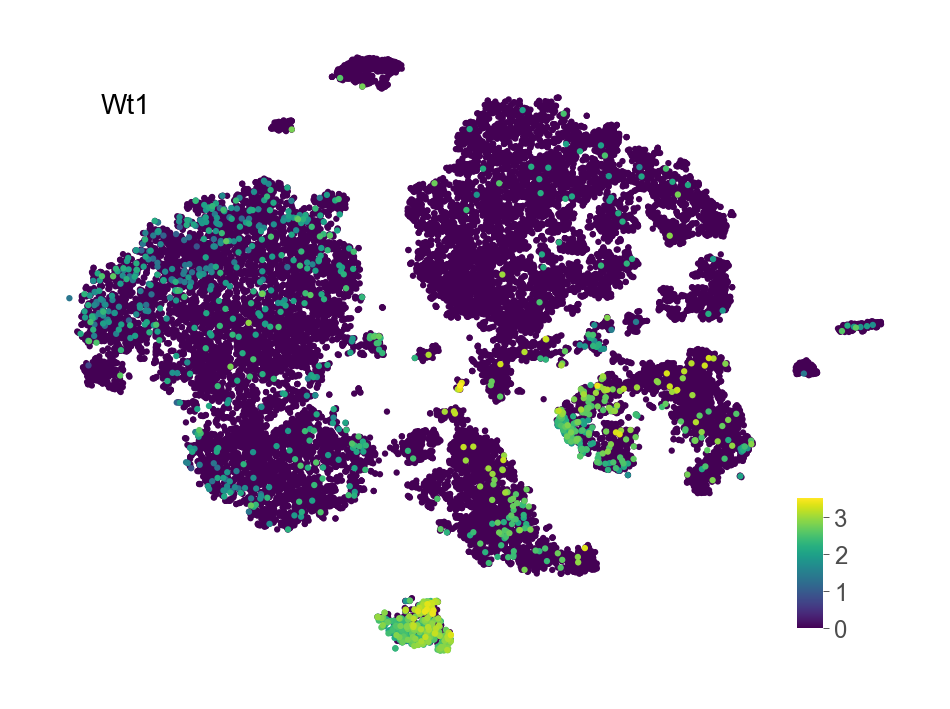

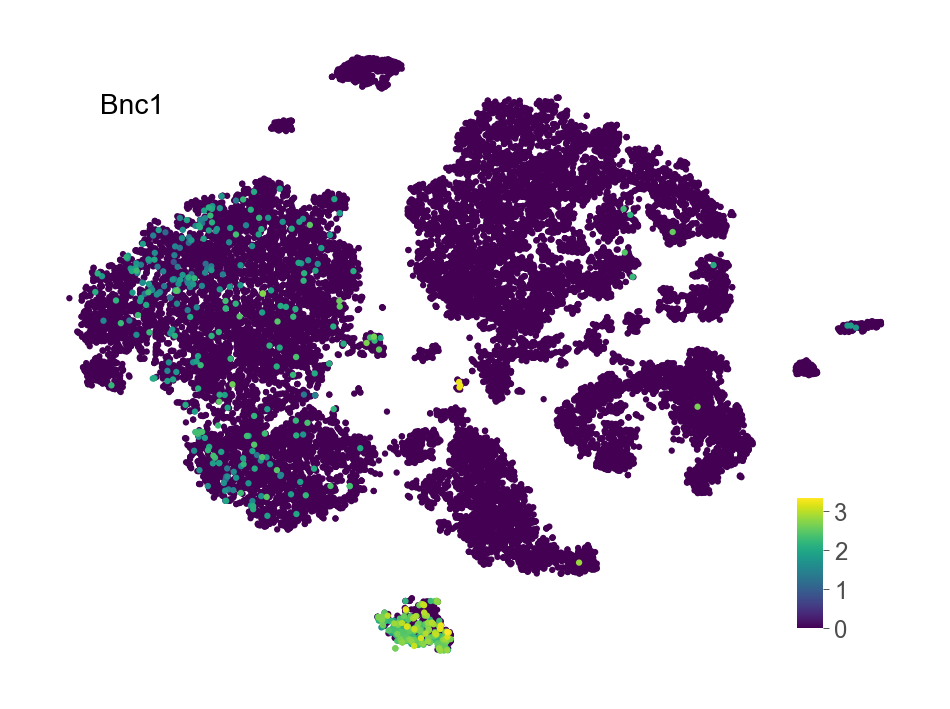

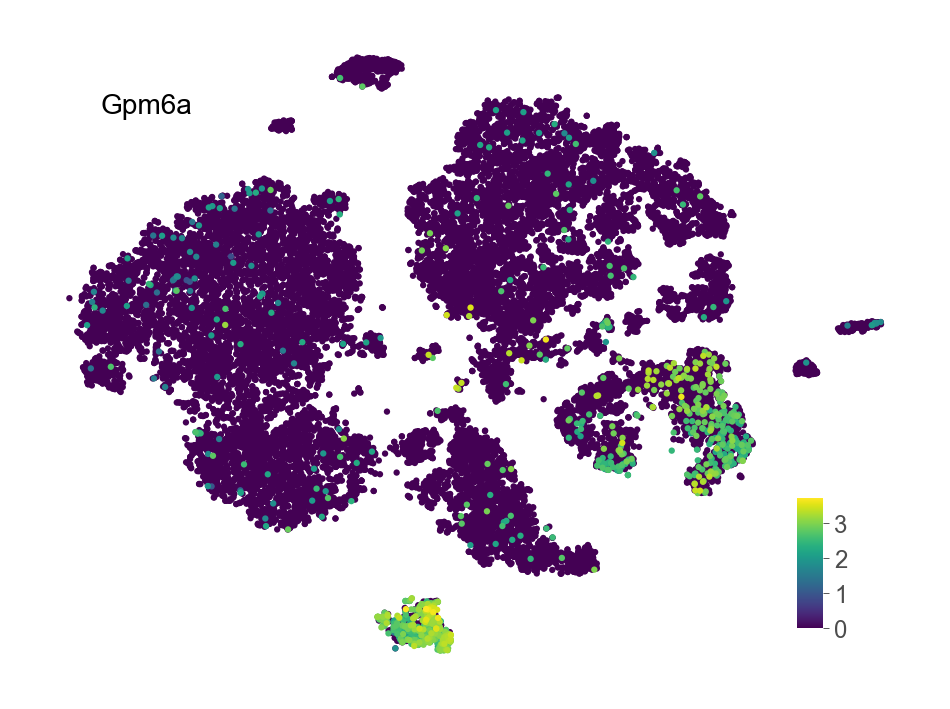

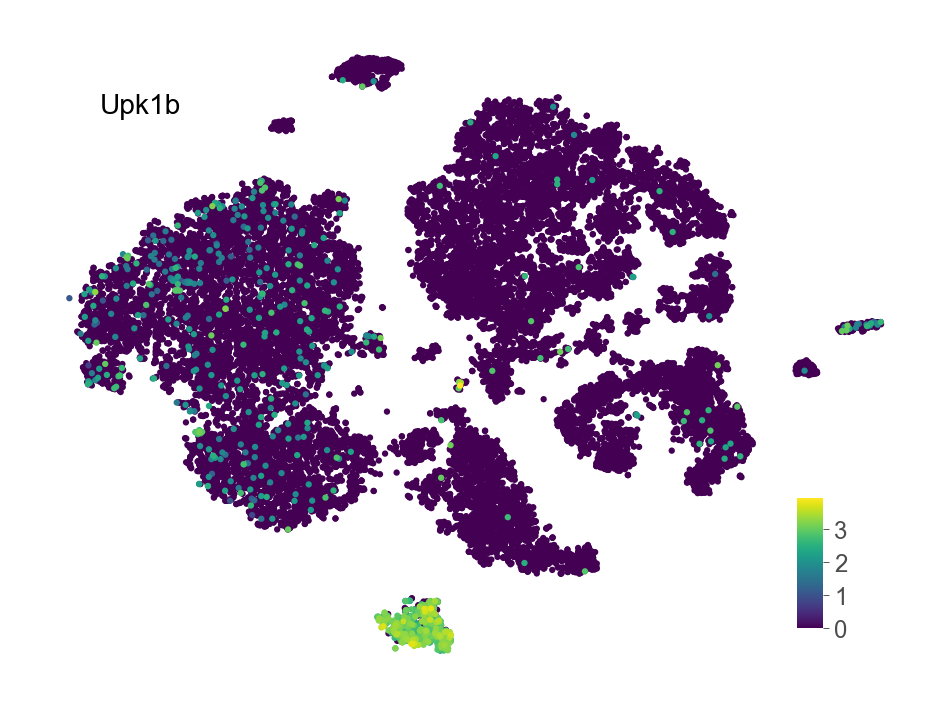

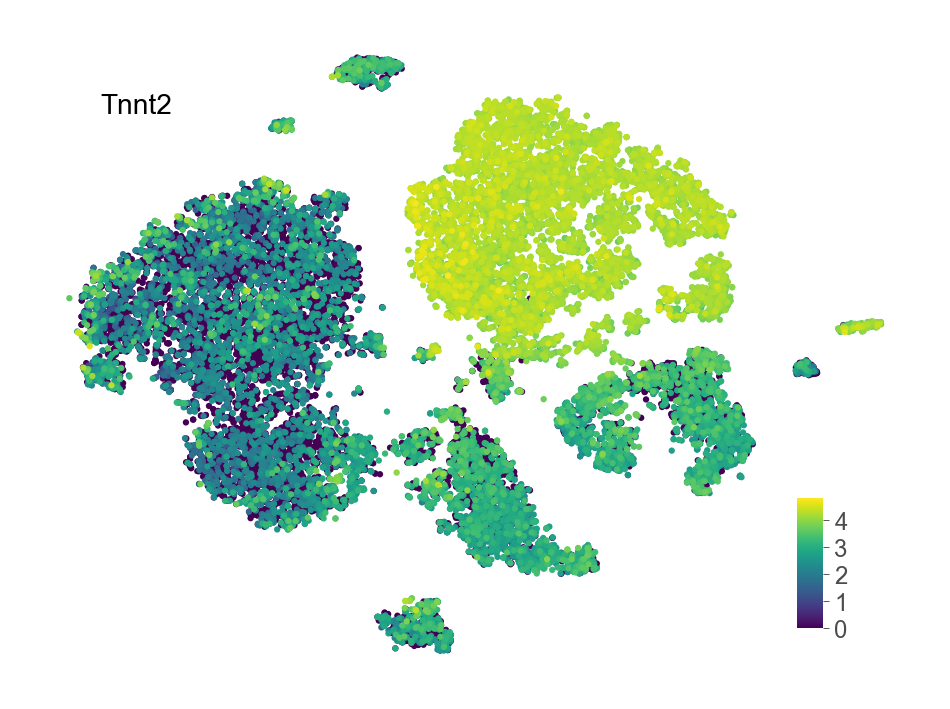

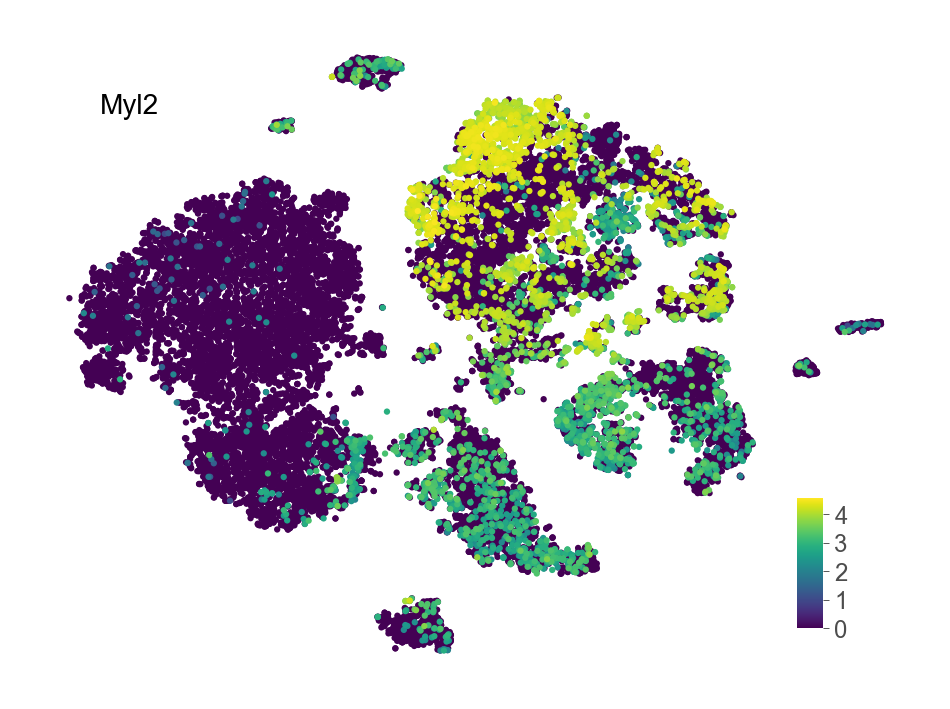

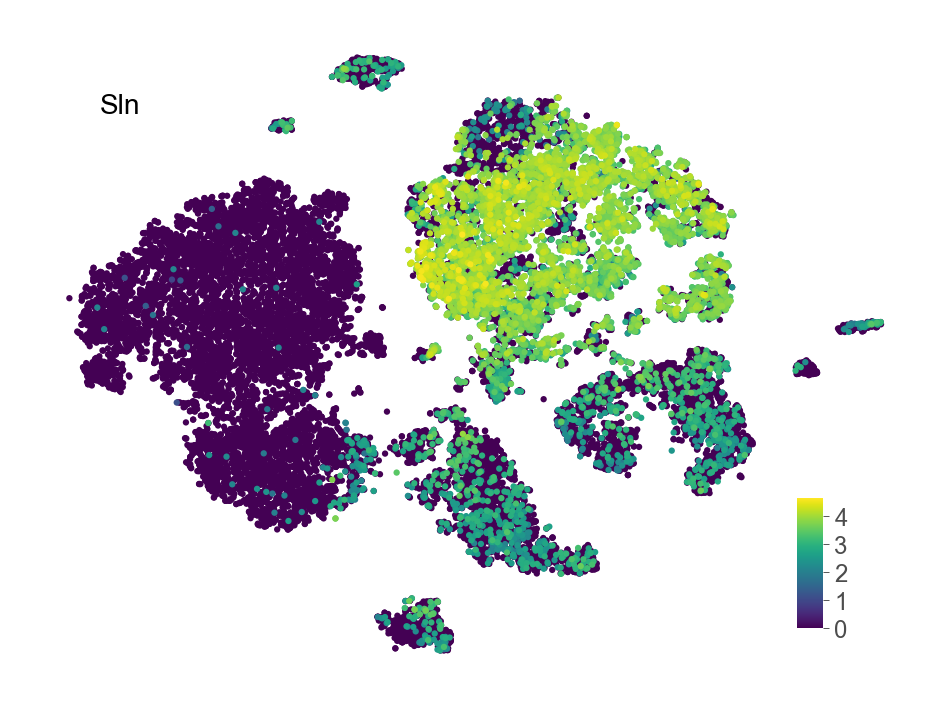

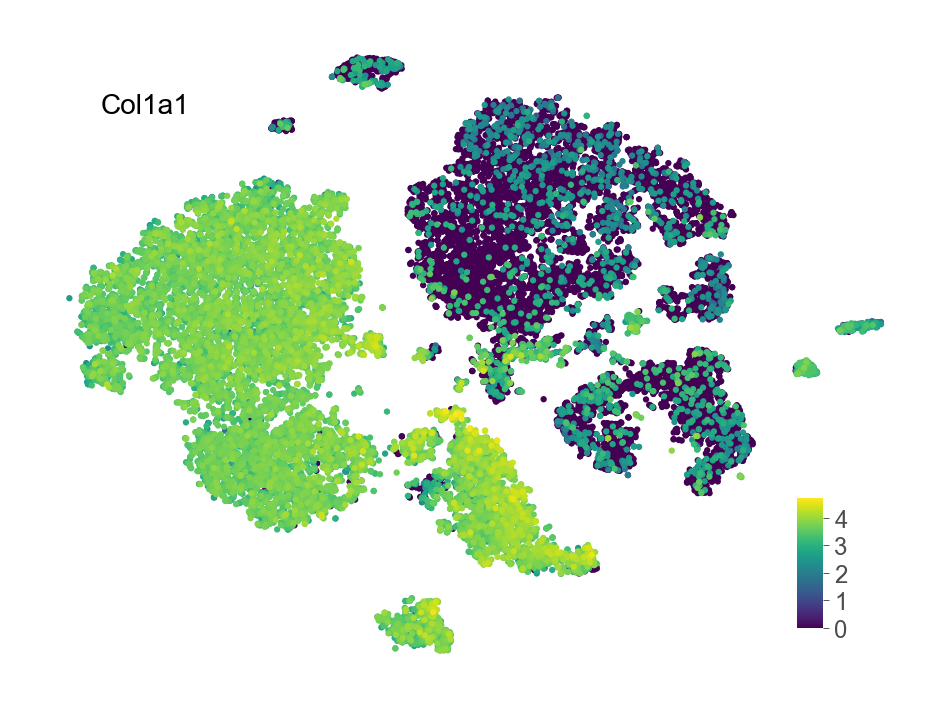

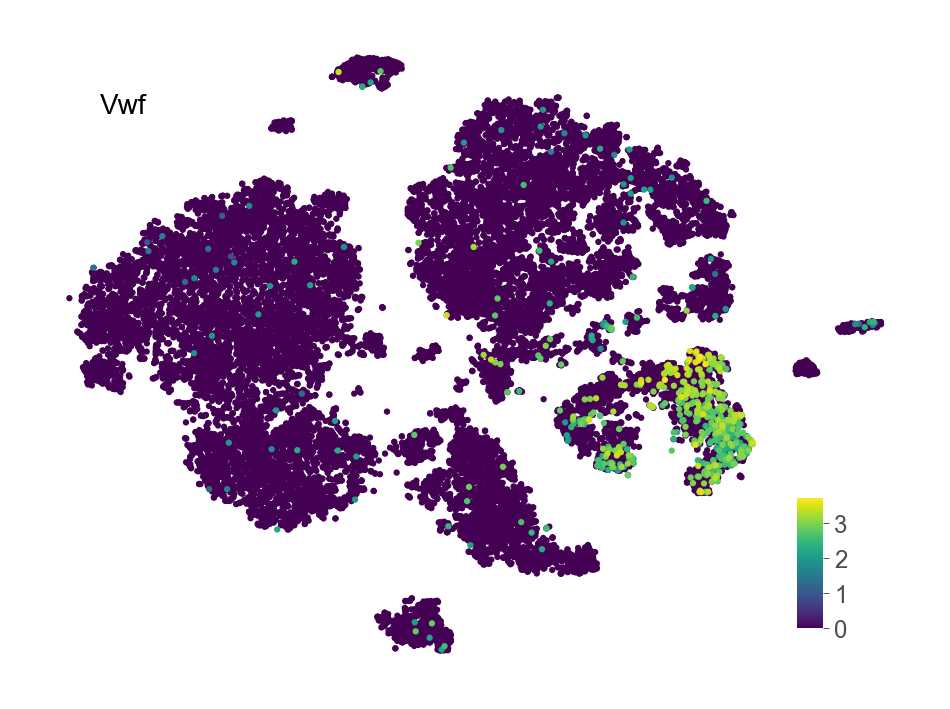

In [76]:
for i in FEATURES_SELECTED:
    print(i.split('_')[1])

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4 * 1, 3 * 1))

    plot_embedding_expr(
        embedding=embedding.loc[:, ['x_tsne', 'y_tsne']],
        expr=extract_feature_values(
            adata=adata_cpm,
            feature_name=i,
            cells_included=embedding.index,
        ),
        figure=fig,
        ax=ax,
        label=i.split('_')[1],
        label_position=(0.08, 0.9),
        colorbar_position=(0.86, 0.08, 0.03, 0.2)
    )

    """
    file_name = ('Pyplot_embedding_expr_'
                 + i
                 + '.pdf')

    if not Path(file_name).is_file():
        fig.savefig(fname=file_name, transparent=True)
    """